<a href="https://colab.research.google.com/github/akshaypt7/energy_predictor/blob/main/EDA_part_2_energy_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy_predictor

In [ ]:
import pandas as pd
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , mean_squared_log_error


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.inspection import permutation_importance, plot_partial_dependence, permutation_importance

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import load_boston

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [ ]:
!pip install pickle5

import pickle5 as pickle
with open('/content/drive/MyDrive/Energy_predictor/train.pkl', "rb") as fh:
  df_train = pickle.load(fh)

In [ ]:

df_building = pd.read_csv('/content/drive/MyDrive/Energy_predictor/building_metadata.csv')


In [ ]:
df_weather_train = pd.read_csv('/content/drive/MyDrive/Energy_predictor/weather_train.csv')

In [ ]:
def memory_reduction(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2   # current memory usage of the dataframe passed
    for column in df.columns:
        column_type = df[column].dtypes  # data type of each cloumn
        if column_type in numerics:
            c_min = df[column].min()  #minimum value in column
            c_max = df[column].max()#maximum value in column
            if str(column_type)[:3] == 'int': # if the column is int object we try to change that into int8 or int16
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # We are checking if the max and min values in this column can be represented by int8 (if it comes in the range of values of int8, we change into int8)
                    df[column] = df[column].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('size of the memory is reduced to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [ ]:

df_train = memory_reduction(df_train)
df_building = memory_reduction(df_building)
df_weather_train = memory_reduction(df_weather_train)

size of the memory is reduced to 289.19 Mb (0.0% reduction)
size of the memory is reduced to  0.03 Mb (60.3% reduction)
size of the memory is reduced to  3.07 Mb (68.1% reduction)


In [ ]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [ ]:
df_train.head()

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

In [ ]:
df_building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [ ]:
df_weather_train.head()

site_id            timestamp  ...  wind_direction  wind_speed
0        0  2016-01-01 00:00:00  ...             0.0    0.000000
1        0  2016-01-01 01:00:00  ...            70.0    1.500000
2        0  2016-01-01 02:00:00  ...             0.0    0.000000
3        0  2016-01-01 03:00:00  ...             0.0    0.000000
4        0  2016-01-01 04:00:00  ...           250.0    2.599609

[5 rows x 9 columns]

In [ ]:
df_merge = df_train.merge(df_building, how = 'left', on = 'building_id') # we have used left, because df_train has the meter_values, we do not need rows whch dont have target variable(meter_values)

In [ ]:
df_merge = df_merge.merge(df_weather_train, how = 'left', on = ['site_id','timestamp'])

#### Adding new features

In [ ]:
df_merge['datetime'] = pd.to_datetime(df_merge['timestamp'])

df_merge['day'] = df_merge['datetime'].dt.dayofyear
df_merge['week'] = df_merge['datetime'].dt.week
df_merge['month'] = df_merge['datetime'].dt.month
df_merge['hour'] = df_merge['datetime'].dt.hour

In [ ]:
df_merge.corrwith(df_merge['meter_reading']) # Corr of features with target

building_id           0.008761
meter                 0.017672
meter_reading         1.000000
site_id               0.011897
square_feet           0.024308
year_built            0.111837
floor_count           0.130224
air_temperature      -0.004132
cloud_coverage        0.006024
dew_temperature      -0.003330
precip_depth_1_hr     0.000509
sea_level_pressure   -0.004216
wind_direction       -0.000078
wind_speed            0.006071
day                  -0.006680
week                 -0.006880
month                -0.006681
hour                  0.000606
dtype: float64

We understand from this corelation of features with target that 'year_built' and 'floor_count' is very well corelated with meter_reading.

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df_merge.corr(), annot =True, cmap= 'YlGnBu')

In [ ]:
df_merge.head()

building_id  meter  ... wind_direction  wind_speed
0            0      0  ...            0.0         0.0
1            1      0  ...            0.0         0.0
2            2      0  ...            0.0         0.0
3            3      0  ...            0.0         0.0
4            4      0  ...            0.0         0.0

[5 rows x 16 columns]

First what we can do is look at the distribution of year_built for all the data, then what we can do is we can look at the d

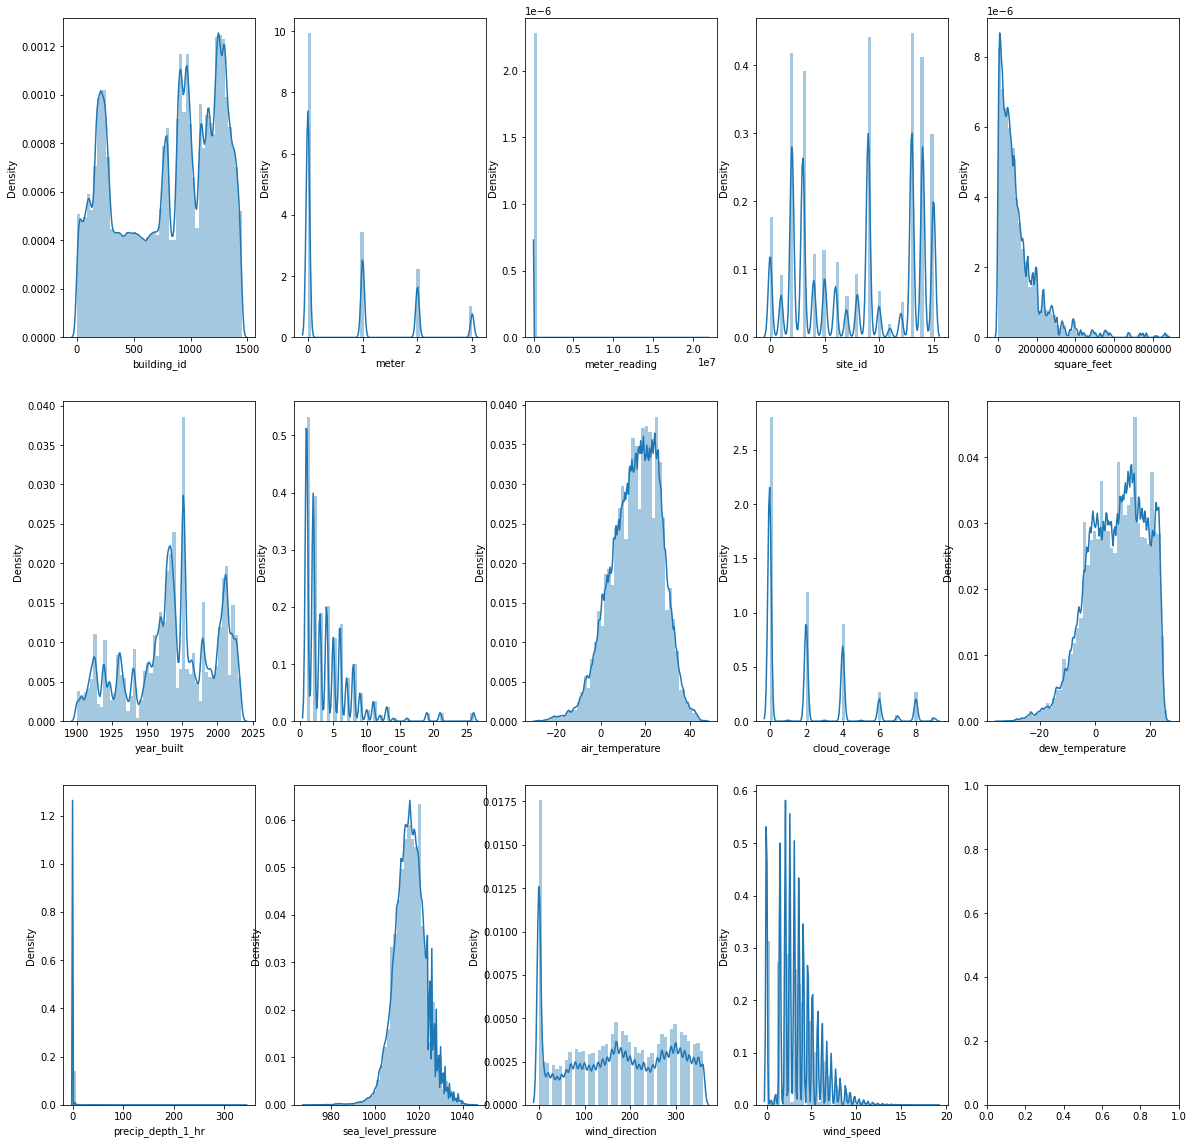

In [ ]:

fig , axes = plt.subplots(nrows=3, ncols = 5, figsize=(20, 20))
axes = axes.flatten()
for ax , col in zip(axes,df_merge.drop(['timestamp','primary_use'], axis=1).columns):
  
  sns.distplot(df_merge[col], ax=ax)

plt.show()


Kind of EDA I can do..
- We understood that year_built and floor count is important. we need to go deeper analysis into how we can fill this 
- how we can work with meter reading, what happens when we take log values of that.
- And then we will also see what happens for other columns also after and before we fill the mean data (like for wind_speed, sea_level,)
- Also see what happens when you combine the features. and then check the corelation.

We need to know for the year_built distribution for each sites (this will help us to understand the method we use for filling is right, we will do after and before). We need to graph it.

How we will visualize it, 

- We groupby site_id and builidng_id, so we have only unique business id, and then remove the building id from there or we not use it. then each site id will have many year built, then we draw the graph of the year_built column

- or I will use query to get the dataframe I want, like for site 1.

### Visualizing Year_built distribution for buildings in each sites

Text(0.5, 1.0, 'site : 0')

Text(0.5, 1.0, 'site : 1')

Text(0.5, 1.0, 'site : 2')

Text(0.5, 1.0, 'site : 3')

Text(0.5, 1.0, 'site : 4')

Text(0.5, 1.0, 'site : 5')

Text(0.5, 1.0, 'site : 6')

Text(0.5, 1.0, 'site : 7')

Text(0.5, 1.0, 'site : 8')

Text(0.5, 1.0, 'site : 9')

Text(0.5, 1.0, 'site : 10')

Text(0.5, 1.0, 'site : 11')

Text(0.5, 1.0, 'site : 12')

Text(0.5, 1.0, 'site : 13')

Text(0.5, 1.0, 'site : 14')

Text(0.5, 1.0, 'site : 15')

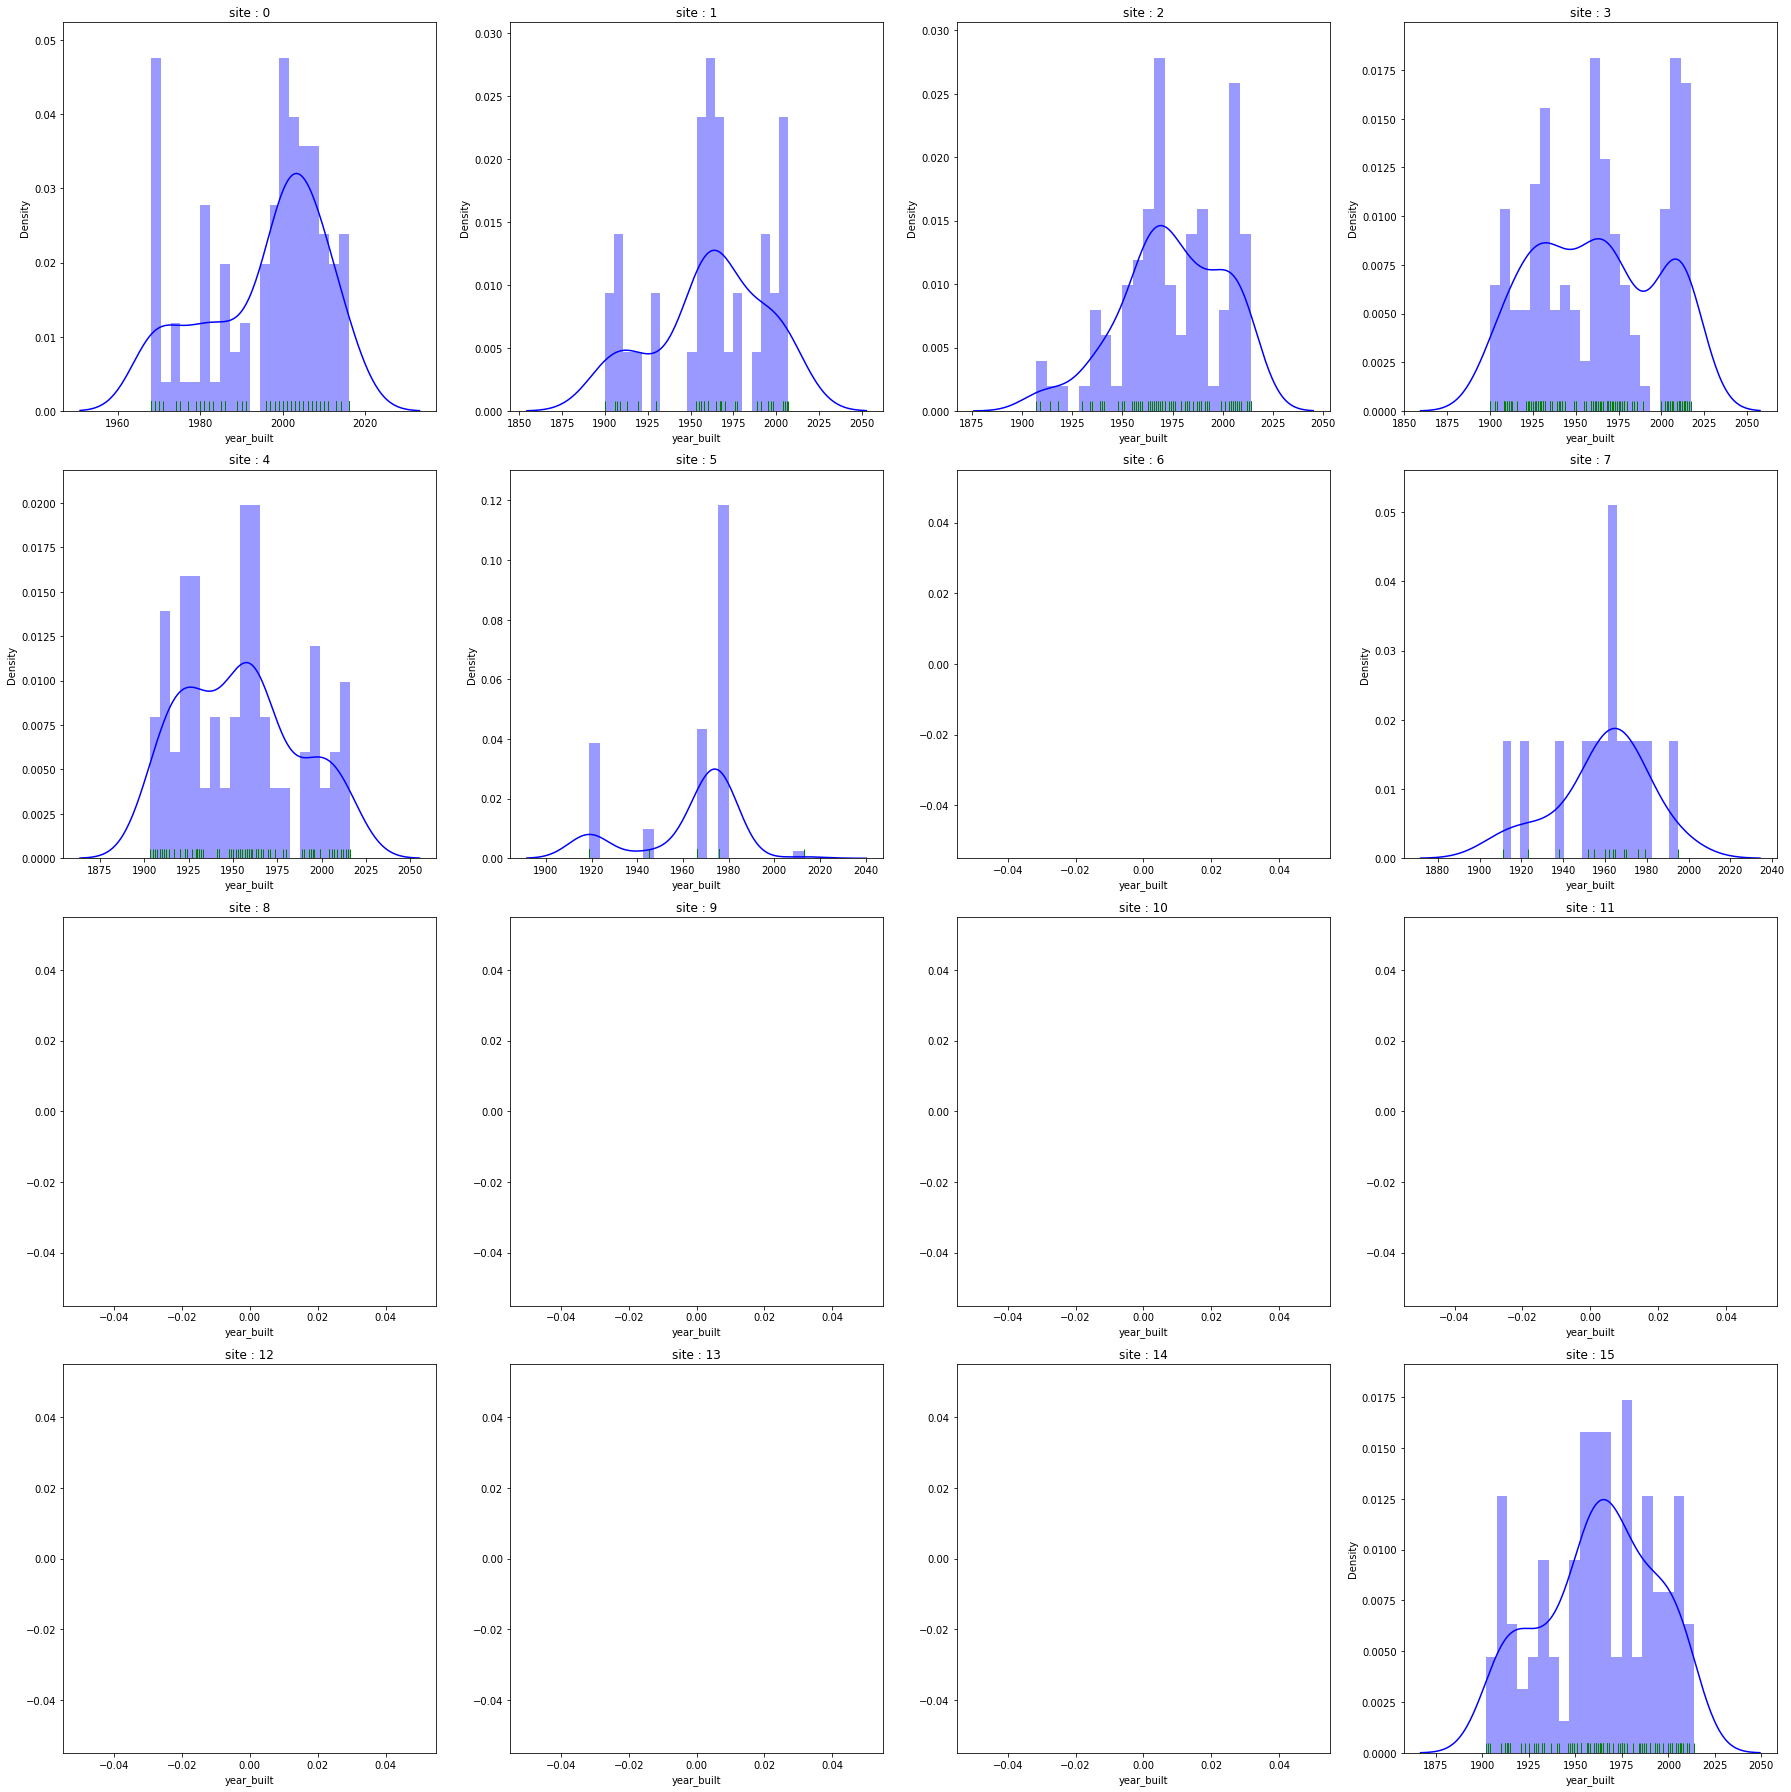

In [ ]:


fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, site in zip(axes.flat, list(range(0,17))):
  df_site = df_merge.query(f'site_id == {site}')
  df = df_site.groupby('building_id').first()
  sns.distplot(df.year_built, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'site : '  +str(site))
plt.show()
  
  






We see that some of the sites do not have the year_built distribution, either it is because the buildings in these sites do not have year_built data or they do not have buildings.


### Visualizing number of buildings in each site.

In [ ]:
num_of_building_in_site = []
for site in range(16):
  df_site = df_merge.query(f'site_id == {site}')
  no_of_building = df_site['building_id'].nunique()
  num_of_building_in_site.append(no_of_building)

<Figure size 720x720 with 0 Axes>

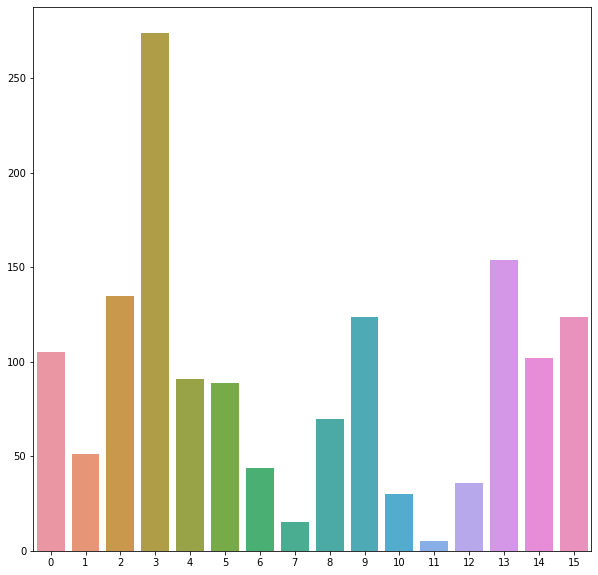

In [ ]:
sites = list(range(0,16))
plt.figure(figsize=(10,10))

sns.barplot(x= sites, y=num_of_building_in_site)

We can confrim now that the sites - 6,8,9,10,11,12,13 and 14 , all have buildings but with the feature 'Year_built' missing


#### We can see that what is number of buildings in each sites that have year_built data and that do not have.

In [ ]:
sites = list(range(0,16))
num_of_building_with_year = []
num_of_building_with_no_year = []
for site in range(16):
  df_site = df_merge.query(f'site_id == {site}')
  df = df_site.groupby('building_id').first()

  building_with_no_year_built = df['year_built'].isna().sum() 

  total_no_of_building = df_site['building_id'].nunique()

  building_with_year_built = total_no_of_building - building_with_no_year_built

  num_of_building_with_year.append(building_with_year_built)
  num_of_building_with_no_year.append(building_with_no_year_built)


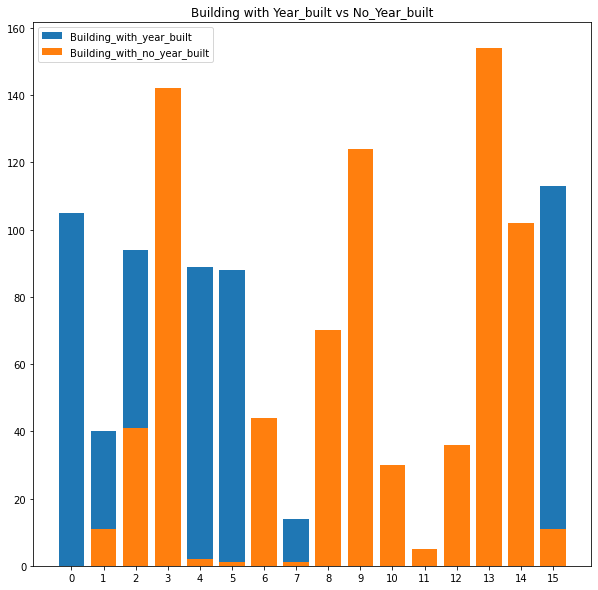

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(sites, num_of_building_with_year, label='Building_with_year_built')
plt.bar(sites, num_of_building_with_no_year, label= 'Building_with_no_year_built')

plt.legend()
plt.xticks(np.arange(16), np.arange(16)) 
plt.title('Building with Year_built vs No_Year_built')
plt.show();

Site 3 has 142 buildings with no year_built and 132 building with year_built data

We need to work on filling this data. and then look at the ditribution.

- for the sites which have both year_built we can use the mean in that site to fill the missing values
- for sites that do not have year_built at all we can fill it with the overall mean value of year_built based on the primary_use of the builing, 
- maybe we can do the same in the first option.


- we also need to know which are the building types that are mostly have missing values for year_built

### Visualizing which type of buildings(primary_use) has more missing_values in year_built

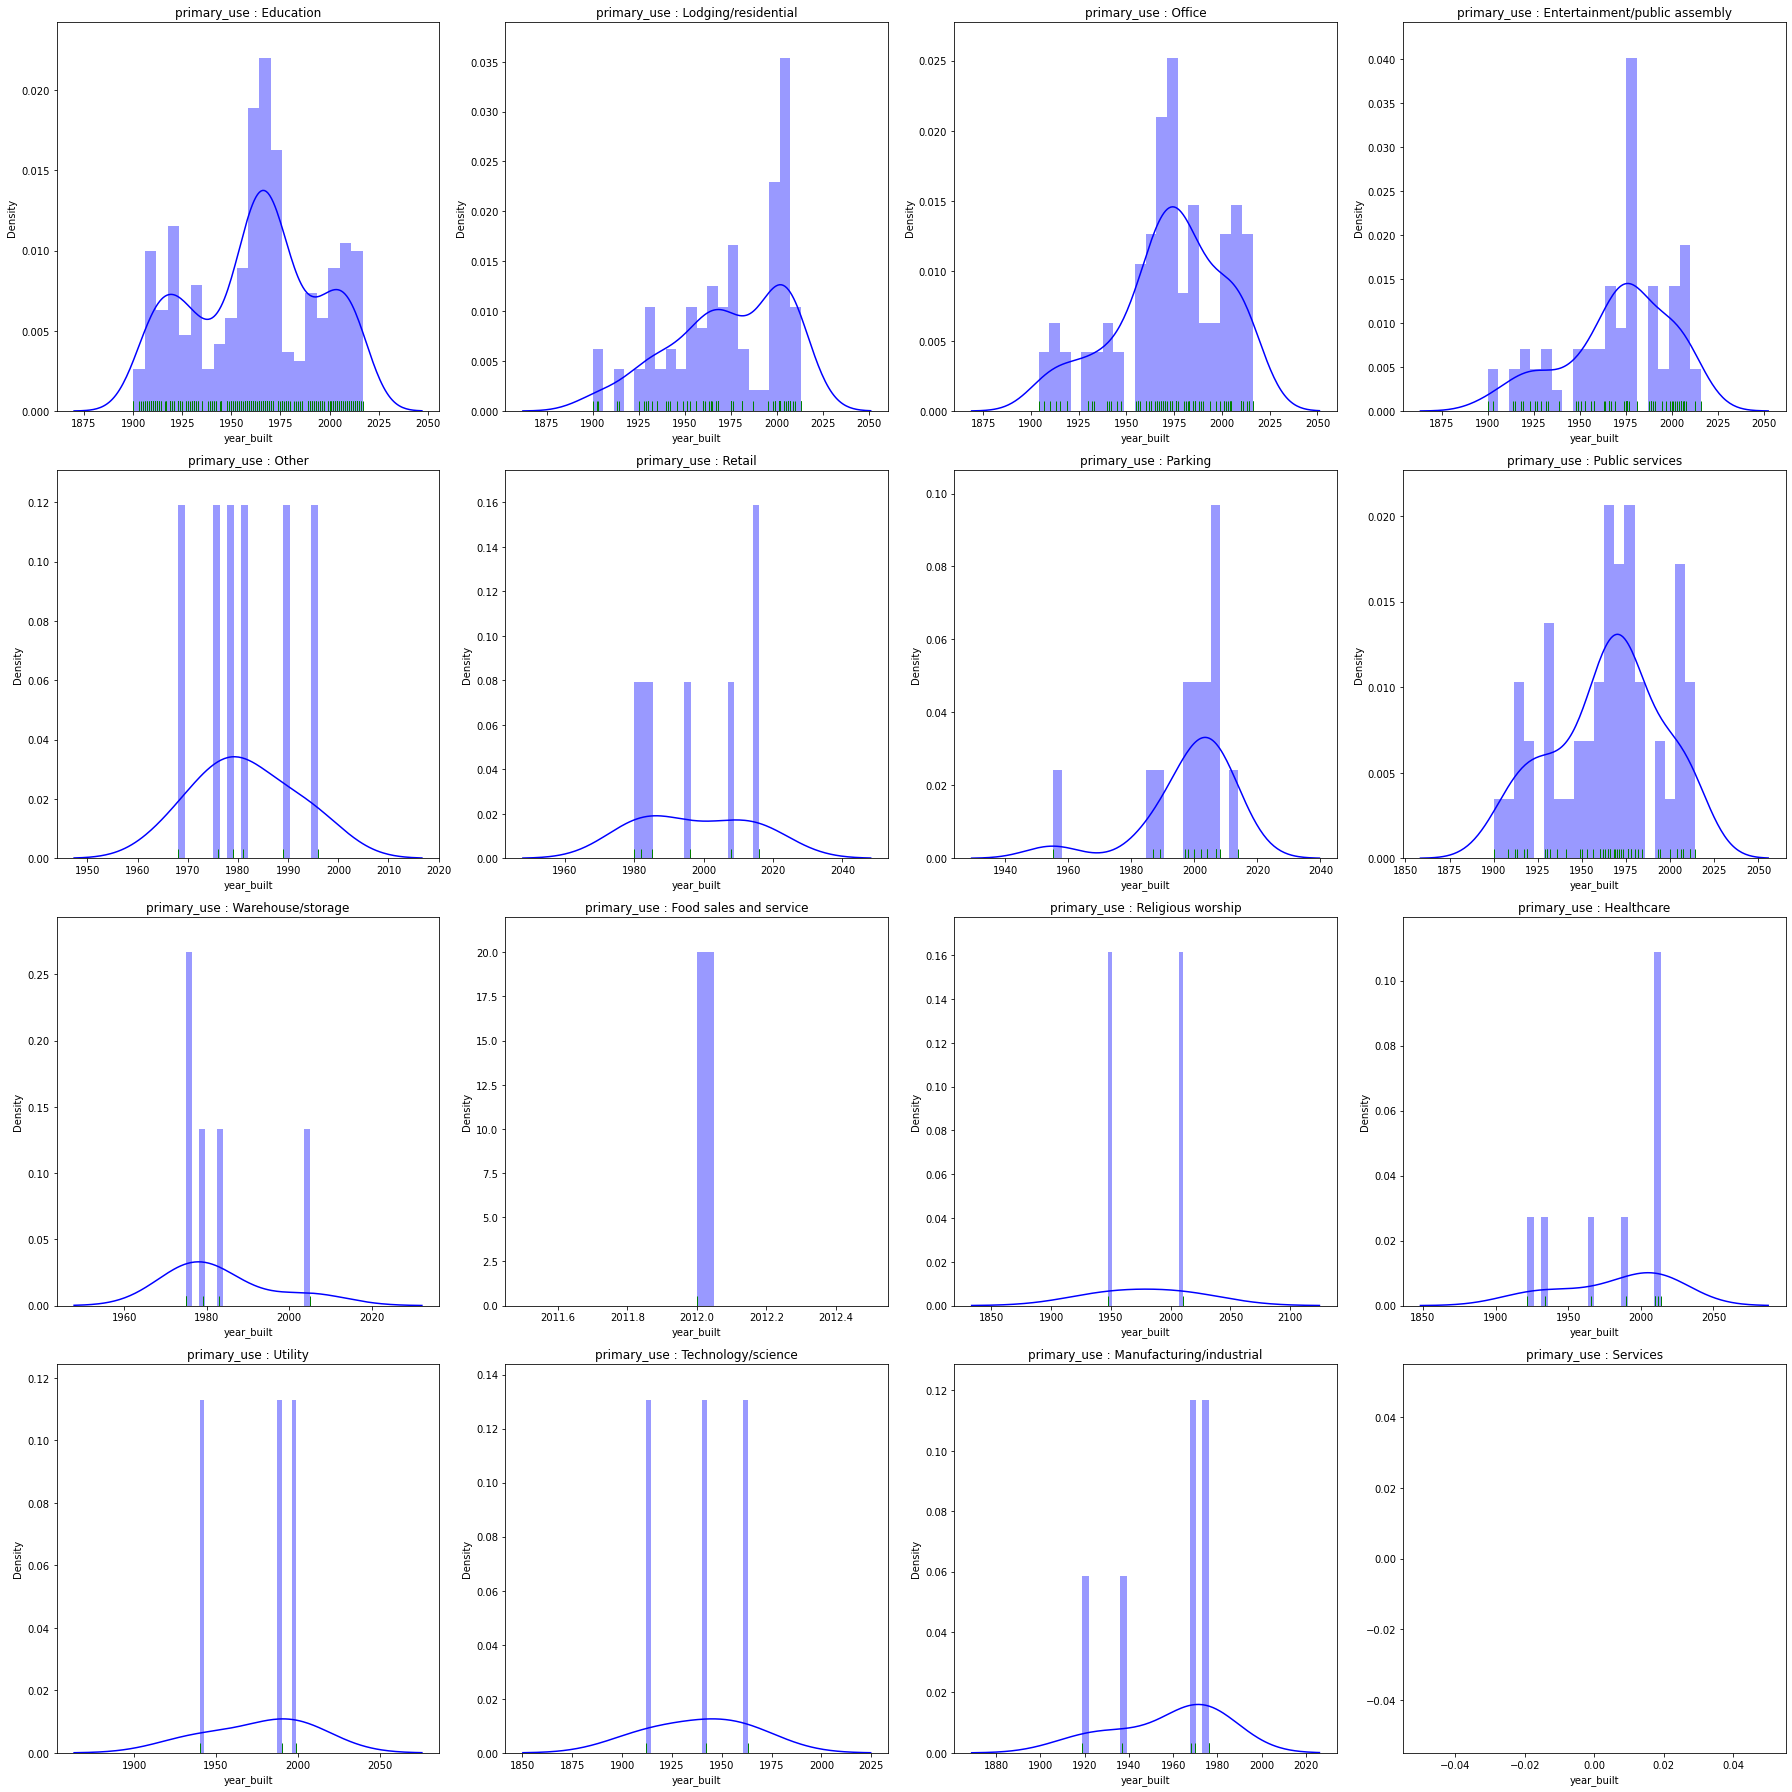

In [ ]:
primary_use_building = df_merge.primary_use.unique()

fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, primary_uses in zip(axes.flat, primary_use_building ):
  string = '"{}"'.format(primary_uses)
  df_primary_use = df_merge.query('primary_use == {}'.format(string))
  df = df_primary_use.groupby('building_id').first()
  sns.distplot(df.year_built, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'primary_use : '  +primary_uses)
plt.show();
  
  


### Filling Missing Values Yearbuilt

We have two options 

1) We can fill the missing values in each site with the mean_value of year_built of all the buildings in that particlaur site. If all the buildings in site doest have year_built, we can take the mean value of entire buildings.

2) We can fill the values with mean of year_built of a particular type of buildiing, ex- we can fill missing values of building who primary_use is education, with mean_value of the budiling whose primary_use is education.


We are choosing the second option, since when we look at the graphs we can see that there is a pattern for buildings with similar primary_use, and there is only one type of building which have no values, but there are many sites with buildings with no year_built.

How do we fill in the values,
1) We can groupby by primary_use and use that to find the mean. 
2) but how will we update the values of missing year_built for differet types of building with this means. 
3) I think this might work, we put primary use as the index, and then when we grouby by primary_use and then find mean, and then use that means to fill in the empty values

In [ ]:
df = df_merge.set_index(['primary_use'])
mean_data=df.groupby(['primary_use'])['year_built'].mean()


In [ ]:
df_primary_use_mean = pd.DataFrame(mean_data)
df_primary_use_mean

year_built
primary_use                              
Education                          1965.0
Entertainment/public assembly      1972.0
Food sales and service             2012.0
Healthcare                         1977.0
Lodging/residential                1972.0
Manufacturing/industrial           1955.0
Office                             1969.0
Other                              1981.0
Parking                            2001.0
Public services                    1964.0
Religious worship                  1979.0
Retail                             1994.0
Services                              NaN
Technology/science                 1930.0
Utility                            1973.0
Warehouse/storage                  1983.0

In [ ]:
df_merge_copy = df_merge.copy()

In [ ]:

df_merge_copy = df_merge_copy.set_index(['primary_use'])

In [ ]:

df_merge_copy.head()

building_id  meter            timestamp  ...  week  month  hour
primary_use                                           ...                   
Education              0      0  2016-01-01 00:00:00  ...    53      1     0
Education              1      0  2016-01-01 00:00:00  ...    53      1     0
Education              2      0  2016-01-01 00:00:00  ...    53      1     0
Education              3      0  2016-01-01 00:00:00  ...    53      1     0
Education              4      0  2016-01-01 00:00:00  ...    53      1     0

[5 rows x 20 columns]

In [ ]:
year_built = df_merge_copy.year_built #  creating a series object

In [ ]:
df_year_built = pd.DataFrame(year_built,columns= ['year_built']) # creating dataframe to perform update

In [ ]:
df_year_built.year_built.isna().sum() # Nan Values

12127645

In [ ]:
df_year_built.update(df_primary_use_mean, overwrite=False) 

# What happens here is df_year_built has the index 'primary_use', so does df_primary_use_mean. They both have the same column(year_built),
# now if a row has missing values in an index say education in df_year_built, it will check for the value of the index 'education' in df_primary_use_mean
# It will use that value to update the value in df_year_built, corresponding to the indexes


In [ ]:
df_merge_copy['year_built'] = df_year_built['year_built'] # updating values in main dataframe

We still have an issue, the 'Services' type do not have any year_built information for any of its buildings. 
We can replace the Nan values with the mean value of all the buildings combined

In [ ]:
mean_value= df_primary_use_mean['year_built'].mean()

In [ ]:
df_merge_copy['year_built'].fillna(value =mean_value,inplace =True)

In [ ]:
tbl_report(df_merge_copy)

Table Shape (20216100, 20)


dtype  ...                                 value_counts
building_id                  int16  ...                                           HC
meter                         int8  ...  0:12060910\n1:4182440\n2:2708713\n3:1264037
timestamp                   object  ...                                           HC
meter_reading              float32  ...                                           HC
site_id                       int8  ...                                           HC
square_feet                  int32  ...                                           HC
year_built                 float16  ...                                           HC
floor_count                float16  ...                                           HC
air_temperature            float16  ...                                           HC
cloud_coverage             float16  ...                                           HC
dew_temperature            float16  ...                                           HC
precip_depth_1_hr          float16  ...                                           HC
sea_level_pressure         float16  ...                                           HC
wind_direction             float16  ...                                           HC
wind_speed                 float16  ...                                           HC
datetime            datetime64[ns]  ...                                           HC
day                          int64  ...                                           HC
week                         int64  ...                                           HC
month                        int64  ...                                           HC
hour                         int64  ...                                           HC

[20 rows x 5 columns]

#### Visualzing Year_built distribution based on Primary_use after filling Nan

In [ ]:
primary_use_building = df_merge.primary_use.unique()

fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, primary_uses in zip(axes.flat, primary_use_building ):
  string = '"{}"'.format(primary_uses)
  df_primary_use = df_merge_copy.query('primary_use == {}'.format(string))
  df = df_primary_use.groupby('building_id').first()
  sns.distplot(df.year_built, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'primary_use : '  +primary_uses)
plt.show();
  
  


Note : When we look at the year_built distribution based on primary_use after and before filling the missing data, we see that the distribution has changed, one reason for that is that in many groups, the buildings has year_built as nan values were very high than the ones with year_built value.

#### Comparison of year_built distribution after and before filling nan values

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,8))

sns.distplot(df_merge['year_built'], ax= axes[0])
sns.distplot(df_merge_copy['year_built'], ax= axes[1])

axes[0].set_title('Before Imputation')
axes[1].set_title('After Imputation')

#### Looking at buildings with primary_use : Services

Note : One more option that we can do is we can remove all the rows which have the building type 'Services', the reason is for many of the features the values are Nan. 

We can look at the data in detail

In [ ]:
string = '"{}"'.format('Services')
df_services = df_merge.query('primary_use == {}'.format(string))
df_services.head()

In [ ]:
tbl_report(df_services)

We see that floor_count and year_built is completly missing for all the buildings with primary_use - Services

Also year_built and floor_count were the features that were highly corrleated with target variable. It makes sense for us to drop these rows enterly. 

We create a dataframe from df_merge_copy (where the year_built is filled), where all the rows of buildings with primary_use services are removed.


In [ ]:
df_merge_copy.shape

In [ ]:
df_merge_wo_services = df_merge_copy.drop('Services')

### Floor_count

the floor_count missing values might be because of those floors might have only ground floor. check for buildings with floor_count =1

How are we going to proceed to work on filling missing values in Floor_count

- Check the distribution of floor_count for the entire data and then
- check the distribution for both based on primary_use and site_id
- See if missing values of floor_count is because the buidling have only ground_floor,

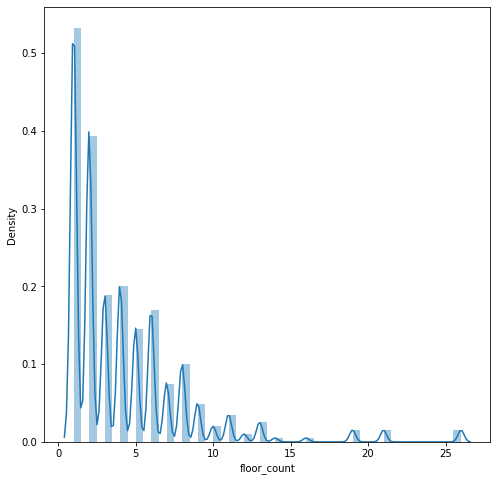

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.distplot(df_merge_copy.floor_count, ax= ax)

#### Visualizing the floor_count distribution based on primary_use

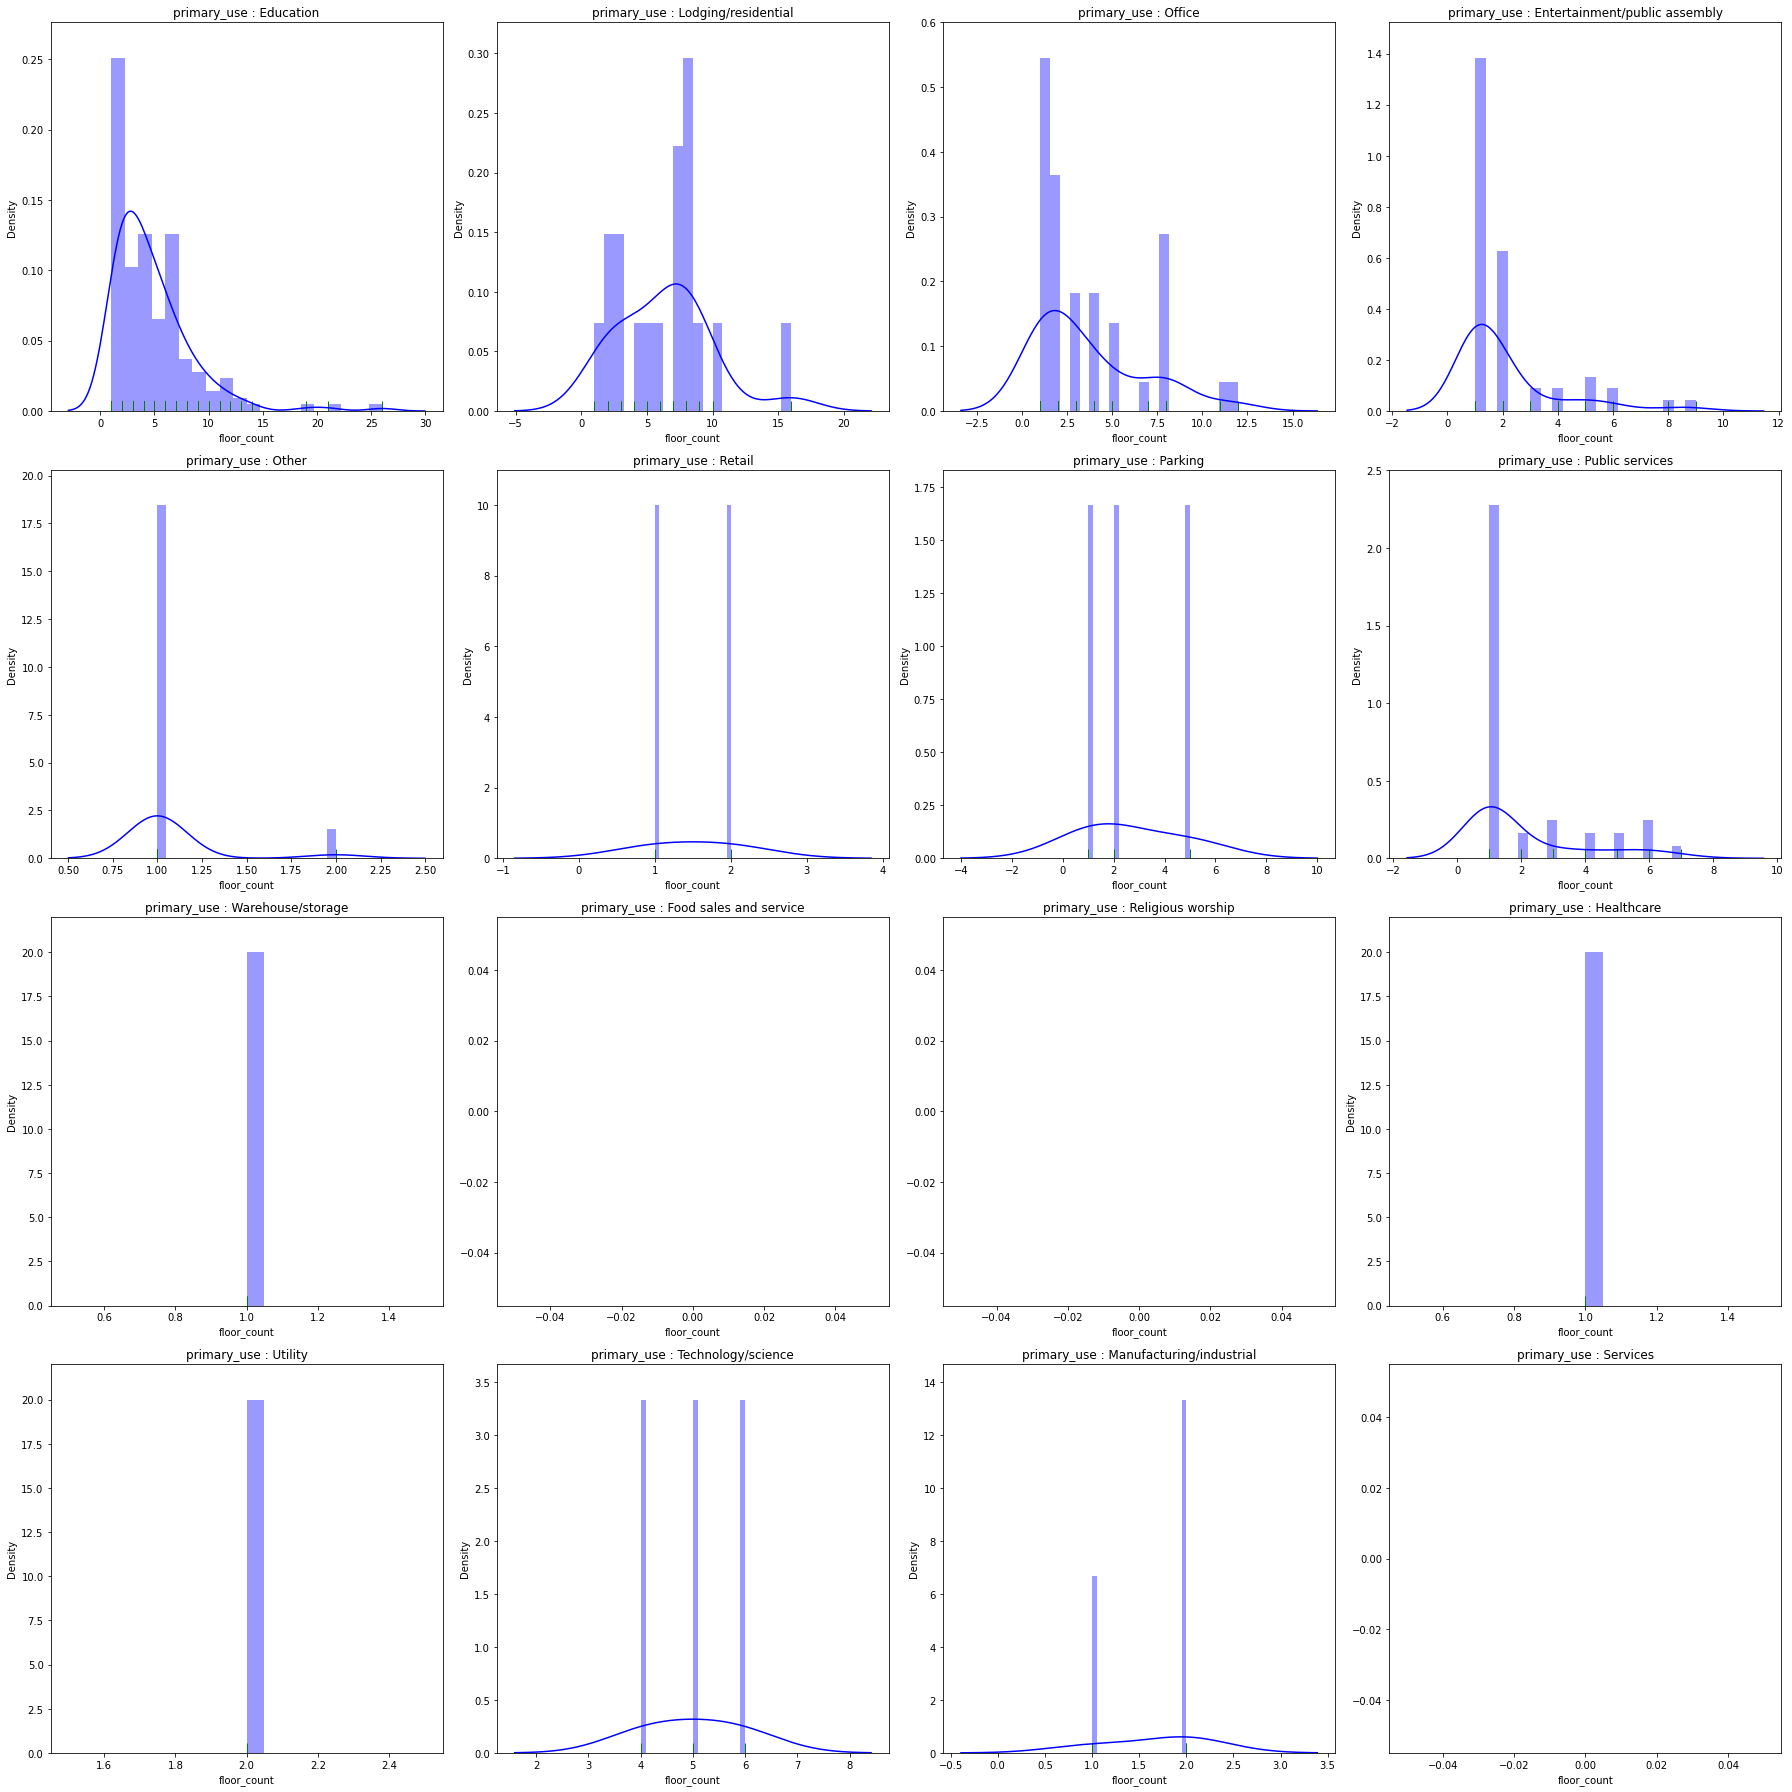

In [ ]:
primary_use_building = df_merge.primary_use.unique()

fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, primary_uses in zip(axes.flat, primary_use_building ):
  string = '"{}"'.format(primary_uses)
  df_primary_use = df_merge.query('primary_use == {}'.format(string))
  df = df_primary_use.groupby('building_id').first()
  sns.distplot(df.floor_count, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'primary_use : '  +primary_uses)
plt.show();
  
  


#### Viz of builidings with floor_count vs without

In [ ]:
len(df_merge.primary_use.unique())

16

In [ ]:
primary_uses = df_merge.primary_use.unique()
num_of_building_with_floor = []
num_of_building_with_no_floor = []
for primary_use in primary_uses:
  string = '"{}"'.format(primary_use)
  df_primary_use = df_merge.query('primary_use == {}'.format(string))
  df = df_primary_use.groupby('building_id').first()
  building_with_no_floor_count = df['floor_count'].isna().sum() 

  total_no_of_building = df_primary_use['building_id'].nunique()

  building_with_floor_count = total_no_of_building - building_with_no_floor_count

  num_of_building_with_floor.append(building_with_floor_count)
  num_of_building_with_no_floor.append(building_with_no_floor_count)


In [ ]:
num_of_building_with_floor,num_of_building_with_no_floor

([172, 18, 40, 56, 13, 2, 3, 41, 2, 0, 0, 1, 1, 3, 3, 0],
 [377, 129, 239, 128, 12, 9, 19, 115, 11, 5, 3, 22, 3, 3, 9, 10])

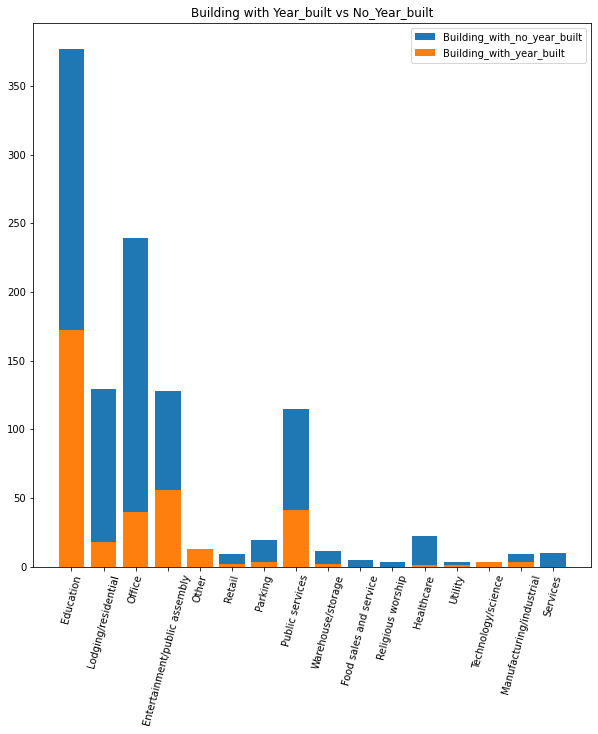

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(sites, num_of_building_with_no_floor, label= 'Building_with_no_year_built')
plt.bar(sites, num_of_building_with_floor, label='Building_with_year_built')




plt.legend()
plt.xticks(np.arange(16), primary_uses) 
plt.title('Building with Floor_count vs No_Floor_count')
plt.xticks(rotation=75)
plt.show();

#### Viz of floor_count distribution based on site id

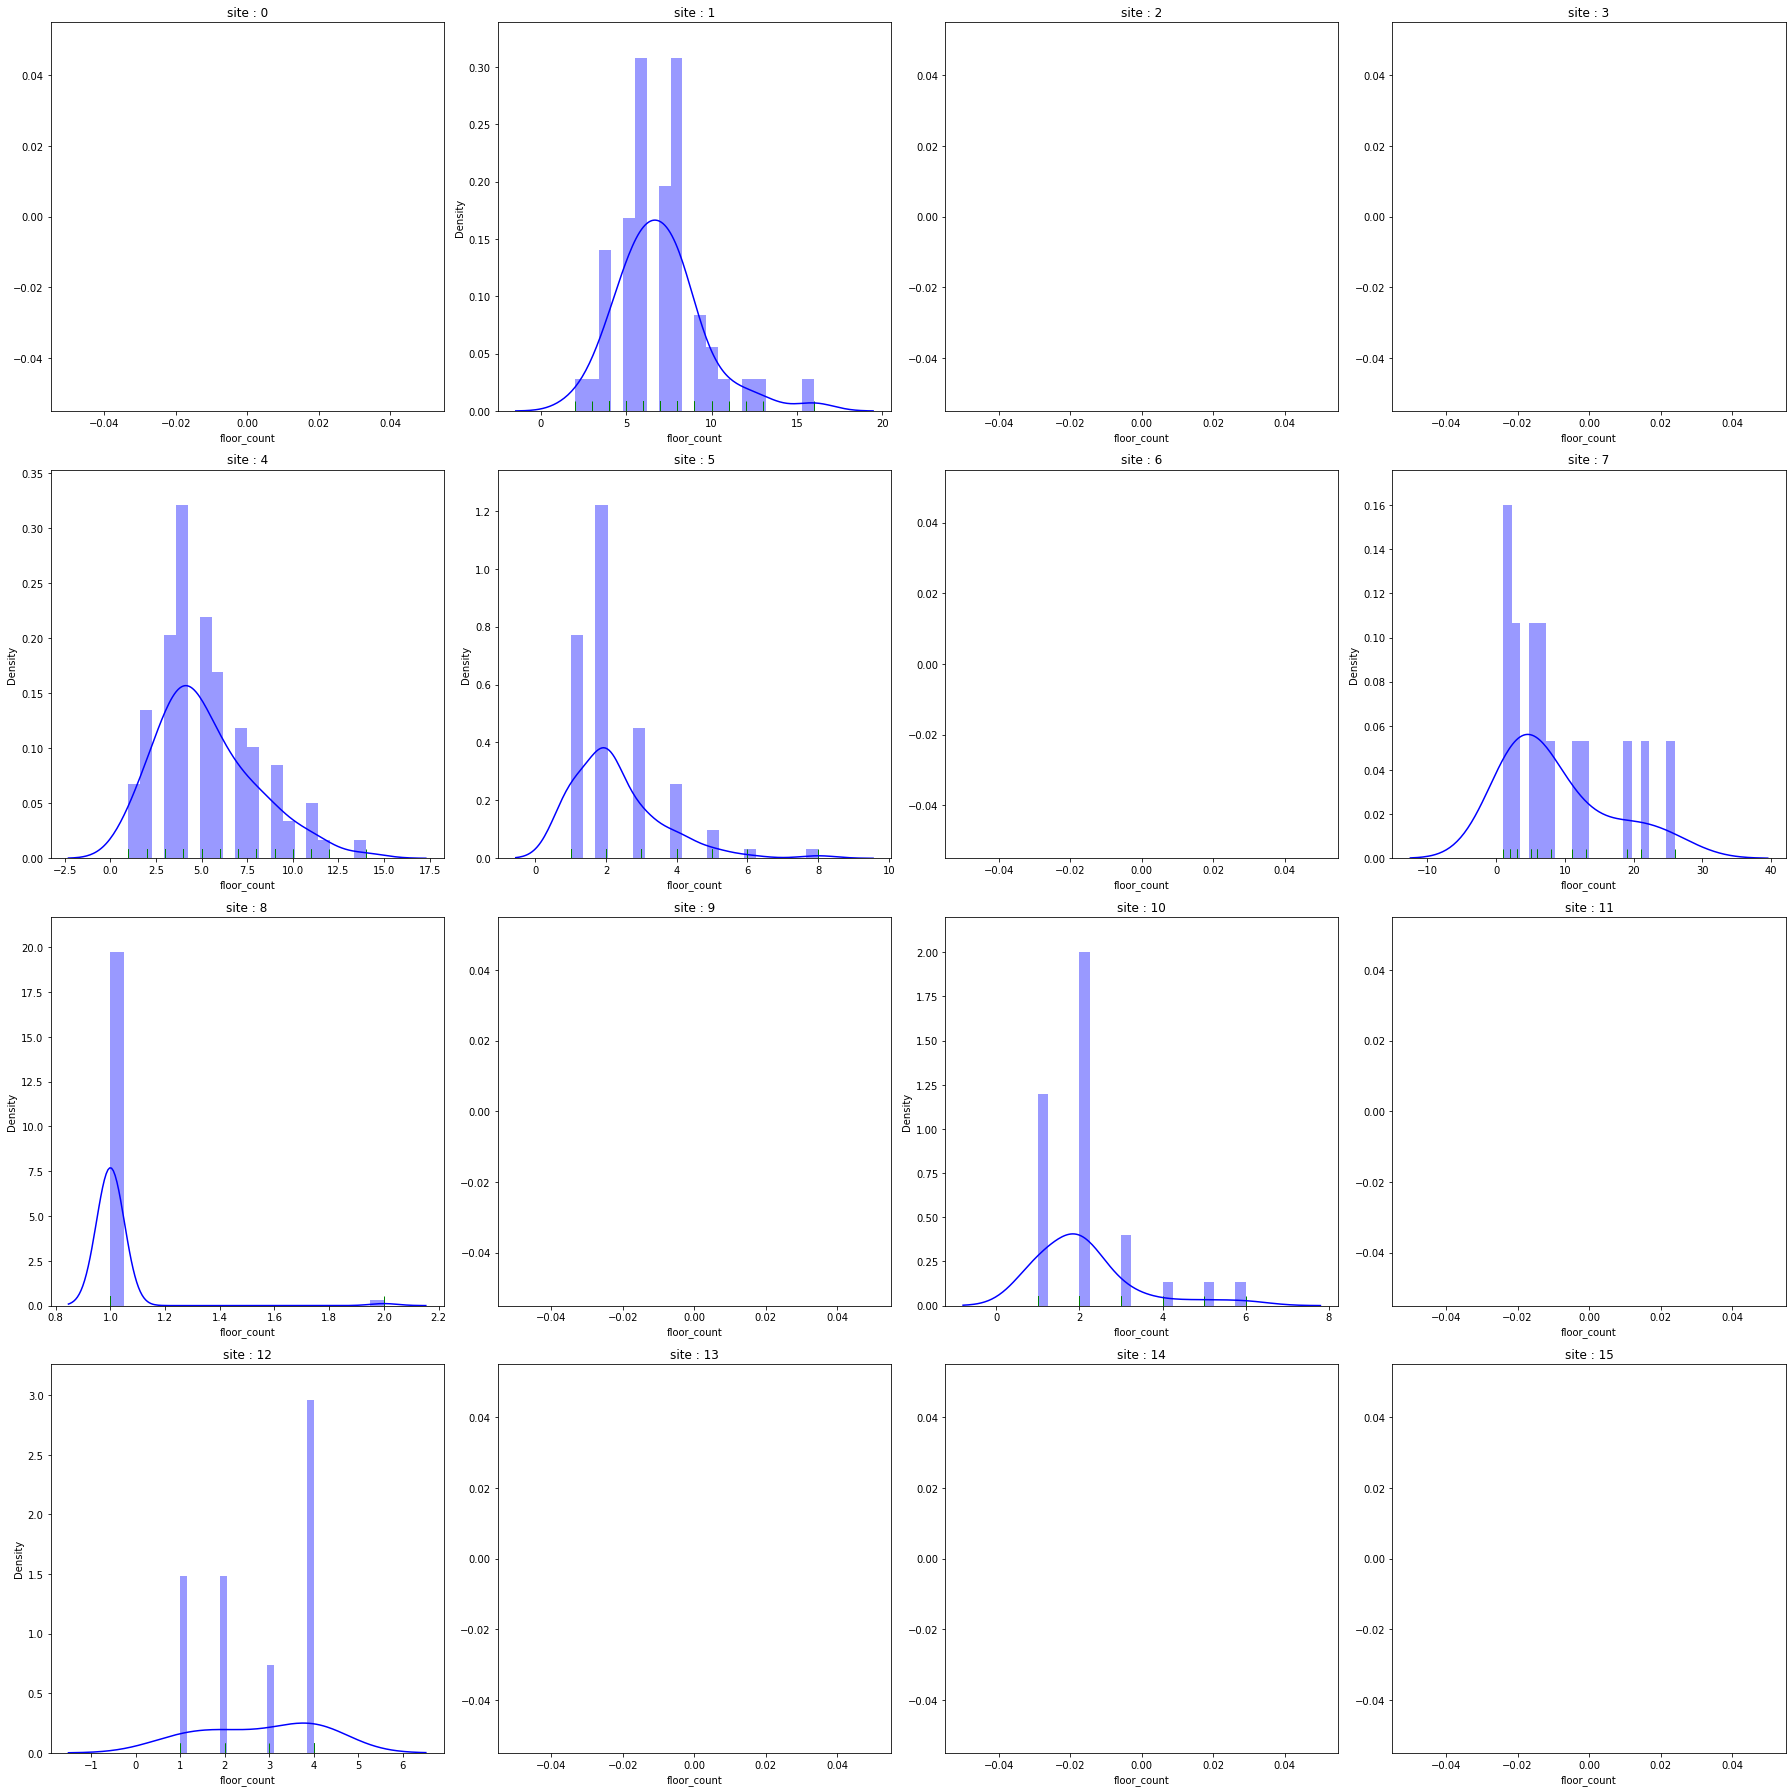

In [ ]:


fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, site in zip(axes.flat, list(range(0,17))):
  df_site = df_merge.query(f'site_id == {site}')
  df = df_site.groupby('building_id').first()
  sns.distplot(df.floor_count, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'site : '  +str(site))
plt.show();
  
  






From viewing both the distribution, it is better if we group by primary_use and then take individual group mean to fill in the nan values

#### Filling floor_count values

In [ ]:
df_merge_floor_count = df_merge_copy.copy()

In [ ]:
mean_floor_count = []
df_floor_mean = df_merge_floor_count.groupby(['primary_use','building_id']).first()

primary_uses = df_merge.primary_use.unique()

for primary_use in primary_uses:
  string = f'"{primary_use}"'
  df_primary = df_floor_mean.query(f'primary_use =={string}')  
  mean_value = df_primary['floor_count'].mean()
  mean_floor_count.append(mean_value)

In [ ]:

df_floor_mean_values = pd.DataFrame(data=mean_floor_count, index= primary_uses, columns=['floor_count'] )

We are filling the Nan values in df_floor_mean_values with 1. We are assuming that all this building will have atleast 1 floor. Also it makes sense to assume building with primary_use: religious will have 1 floor.

In [ ]:
df_floor_mean_values.fillna(1, inplace=True)

In [ ]:
df_floor_mean_values=df_floor_mean_values.round(0).astype('int32')

In [ ]:
df_merge_floor_count.update(df_floor_mean_values, overwrite =False)

#### Floor_count distribution after filling missing values (based on primary_use)

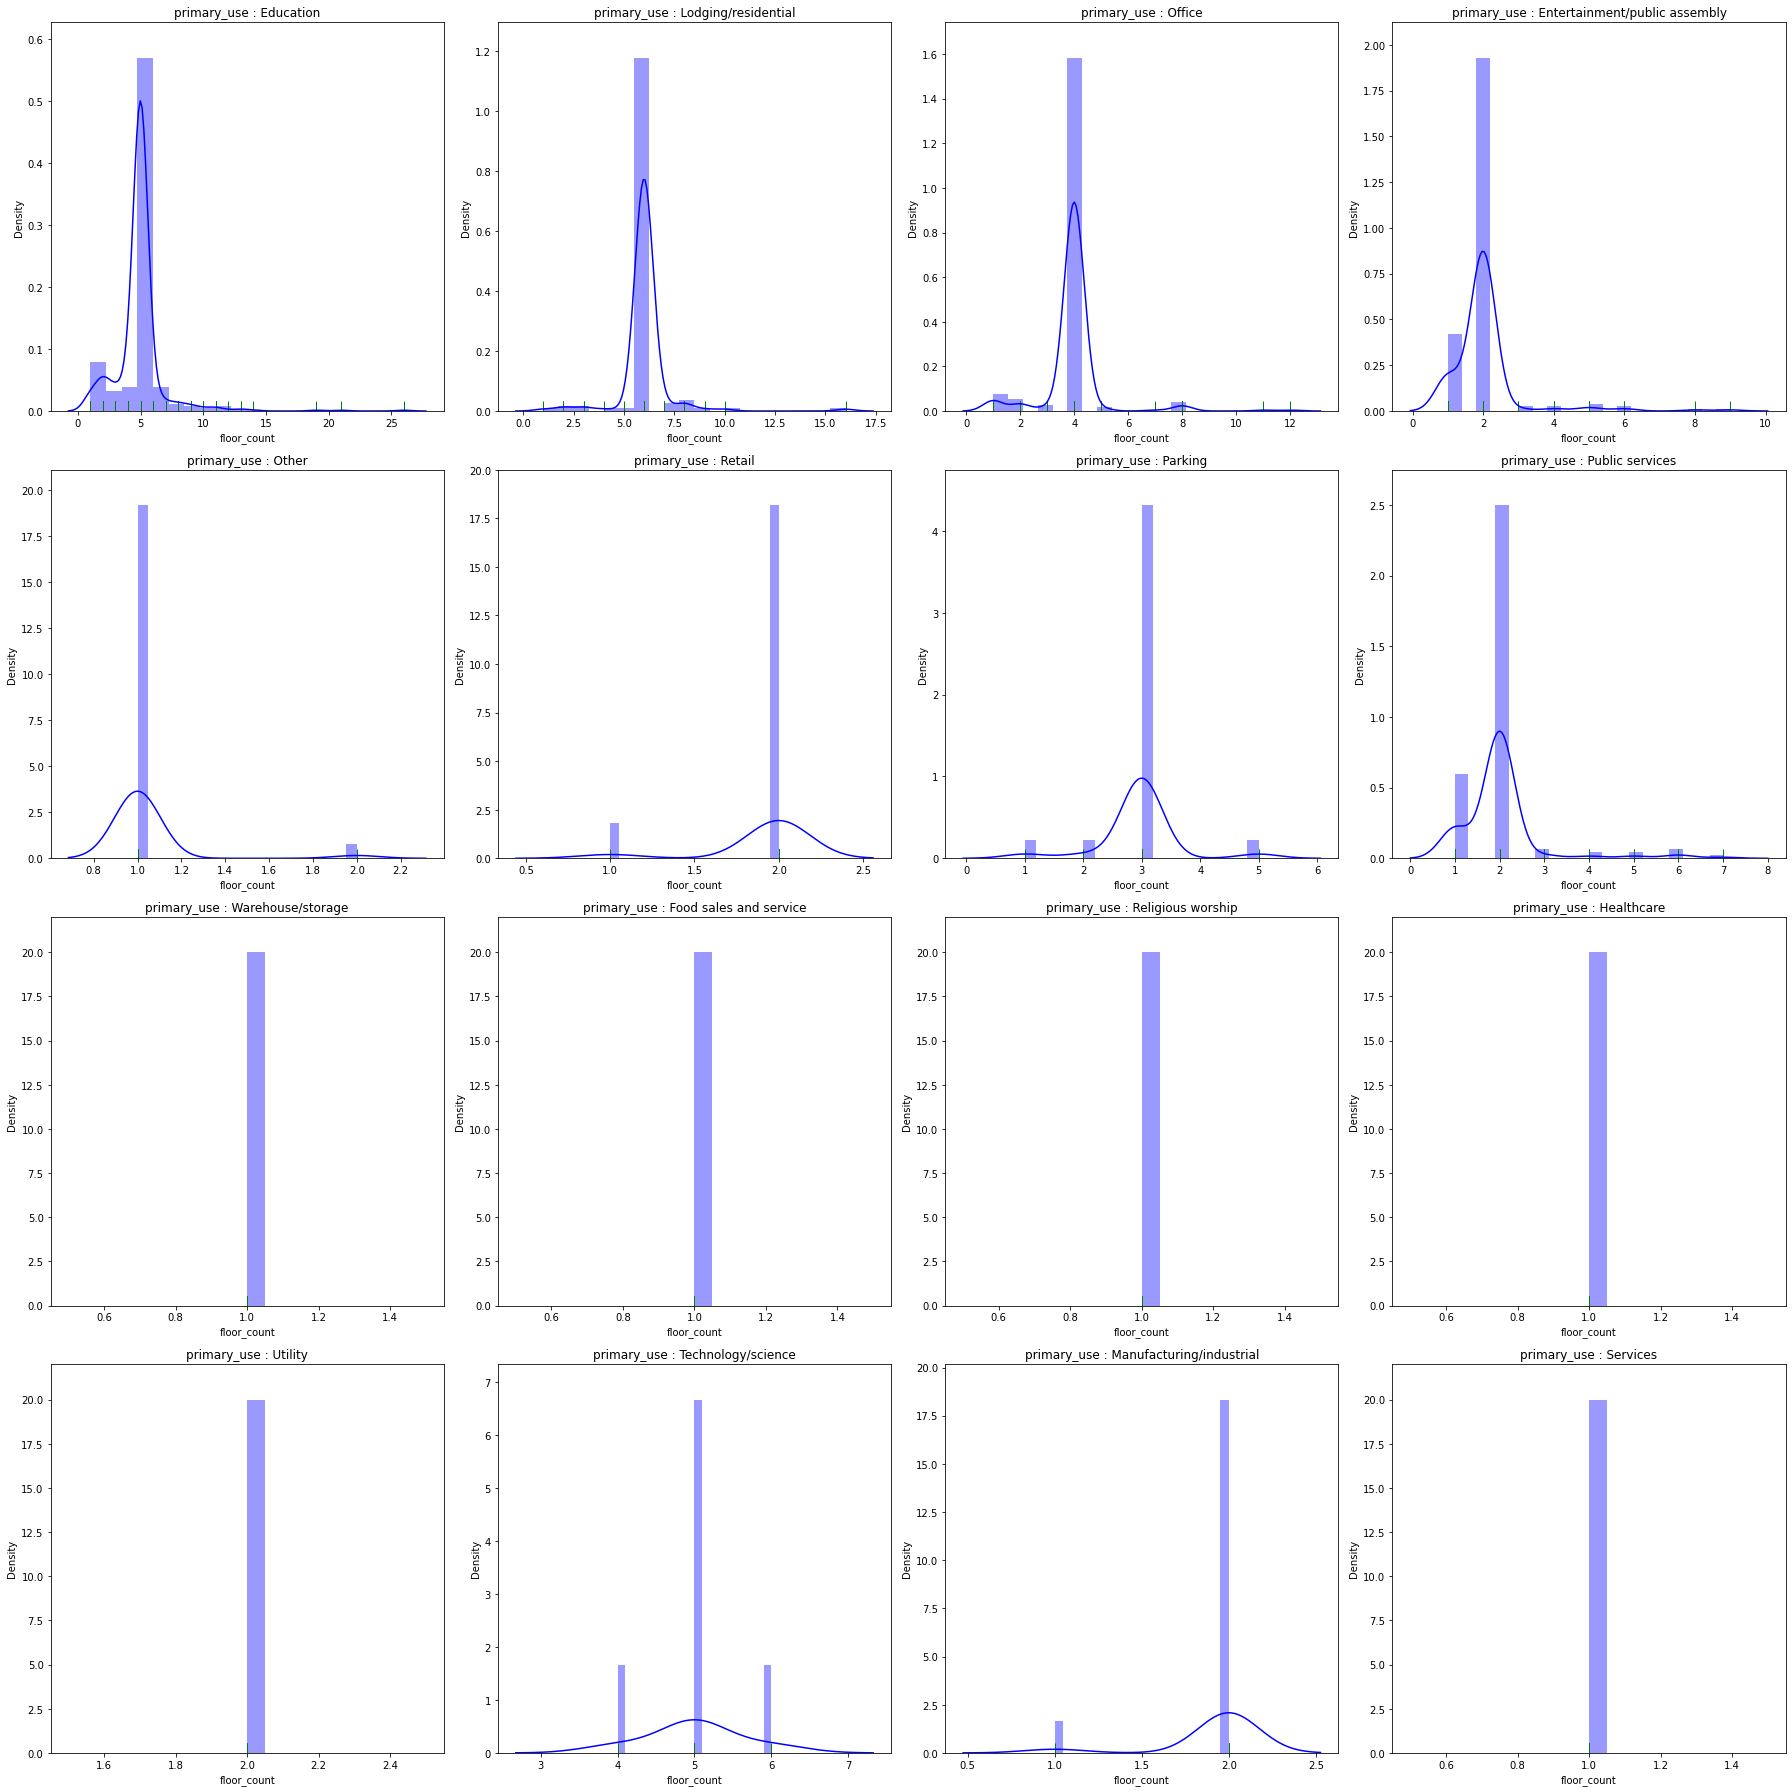

In [ ]:
primary_use_building = df_merge.primary_use.unique()

fig, axes = plt.subplots(nrows = 4, ncols= 4, figsize = (25,25), tight_layout =True)


for ax, primary_uses in zip(axes.flat, primary_use_building ):
  string = '"{}"'.format(primary_uses)
  df_primary_use = df_merge_floor_count.query('primary_use == {}'.format(string))
  df = df_primary_use.groupby('building_id').first()
  sns.distplot(df.floor_count, ax=ax,bins =20, color ='blue', rug = True, rug_kws={'color':'g'}, hist_kws={'linewidth':3})
  ax.set_title( 'primary_use : '  +primary_uses)
plt.show();
  
  


Pre-Processing

A lot of the low values of the target variable seem to be noise (as discussed multiple times in the forums, specifically for site-0) and removing these rows from the training data gives a good boost in score which has been done by several other competitors too.

It was the most time consuming task as we visualized and wrote code to remove these rows for each of the 1449 buildings manually. We could have used a set of heuristics but that is not optimal due to some edge cases so we just decided to spend few minutes on every building and remove the outliers.

In [ ]:
# Crashed - lot of data to process
# sns.displot(data= df_merge_floor_count,x='meter_reading')

### new


In [ ]:

df_merge.head()

building_id  meter            timestamp  ...  week  month hour
0            0      0  2016-01-01 00:00:00  ...    53      1    0
1            1      0  2016-01-01 00:00:00  ...    53      1    0
2            2      0  2016-01-01 00:00:00  ...    53      1    0
3            3      0  2016-01-01 00:00:00  ...    53      1    0
4            4      0  2016-01-01 00:00:00  ...    53      1    0

[5 rows x 21 columns]

In [ ]:
df_merge.timestamp.nunique()

8784

In [ ]:
df_merge_floor_count = df_merge_floor_count.reset_index()

In [ ]:
df_merge_floor_count.head()

primary_use  building_id  ...  wind_direction wind_speed
0   Education            0  ...             0.0        0.0
1   Education            1  ...             0.0        0.0
2   Education            2  ...             0.0        0.0
3   Education            3  ...             0.0        0.0
4   Education            4  ...             0.0        0.0

[5 rows x 16 columns]

In [ ]:
df_meter_0 = df_merge.query(f'meter=={0}')
df_meter_0.shape

(12060910, 21)

In [ ]:
df_meter_1 = df_merge.query(f'meter=={1}')
df_meter_1.shape

(4182440, 21)

In [ ]:
df_meter_2 = df_merge.query(f'meter=={2}')
df_meter_2.shape

(2708713, 21)

In [ ]:
df_meter_3 = df_merge.query(f'meter=={3}')

We can look at the distribution of meter_reading for each of the meter

- we can also look at the meter_reading distribution for each meter at all 16 sites and based on primary_use. 
  - We can show all the 4 types of meter_reading in a single plot, (4 reading have 4 diff color)
- But we also need to look at the distribution of meter reading of 1500 buildings, we might have to drop some rows of builings which are not useful - This we can try after building a model too as well.  

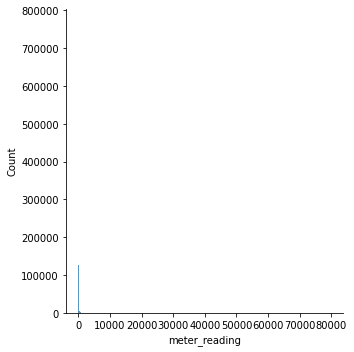

In [ ]:
sns.displot(data= df_meter, x= 'meter_reading')

Since the distribution of the meter_reading is very skewed, we are now looking at the distributions for each of the meters seperately

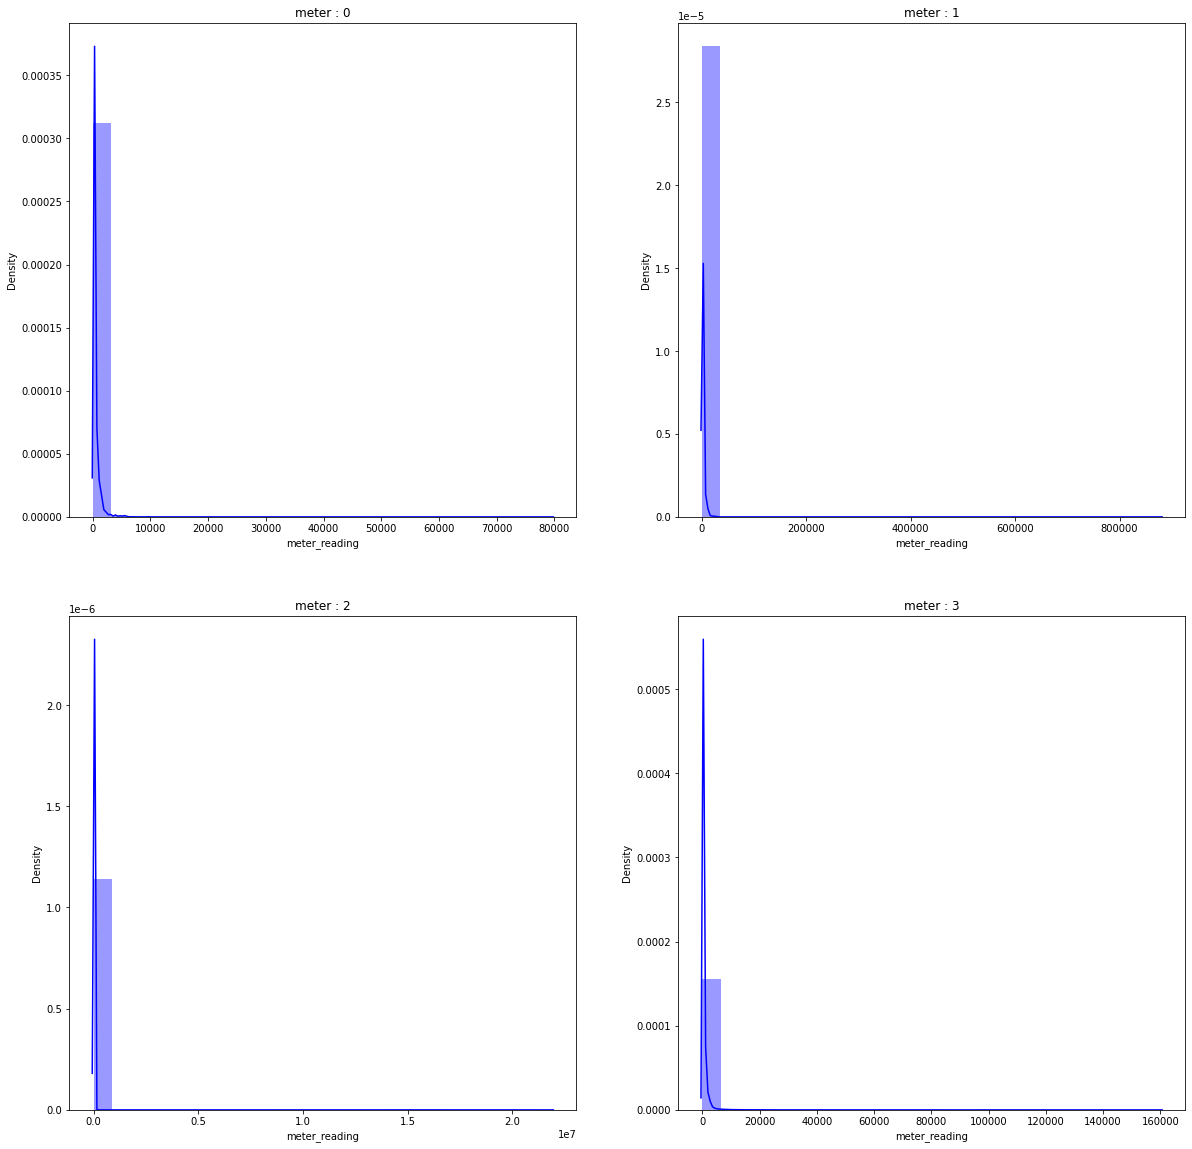

In [ ]:
fig ,axes = plt.subplots(2,2, figsize=(20,20))
meters = [0,1,2,3]
for meter,ax in zip(meters, axes.flat):
  df_meter = df_merge.query(f'meter=={meter}')
  sns.distplot(df_meter['meter_reading'], kde=True, bins =25, color='blue', ax=ax)
  ax.set_title('meter : '+ str(meter) )


plt.show();

In [ ]:
df_meter_0.meter_reading.max()

79769.0

In [ ]:
df_meter_2.meter_reading.max() # we need to remove outliers like this

21904700.0

In [ ]:
df_meter_2.meter_reading.value_counts() # A large percentage is zero 

0.000000        346960
36.599998        21017
24.400000        20122
33.549999        19616
27.450001        18280
                 ...  
52.746601            1
13503.200195         1
52.746899            1
52.747299            1
24.877600            1
Name: meter_reading, Length: 643087, dtype: int64

##### Meter_reading distribution in log

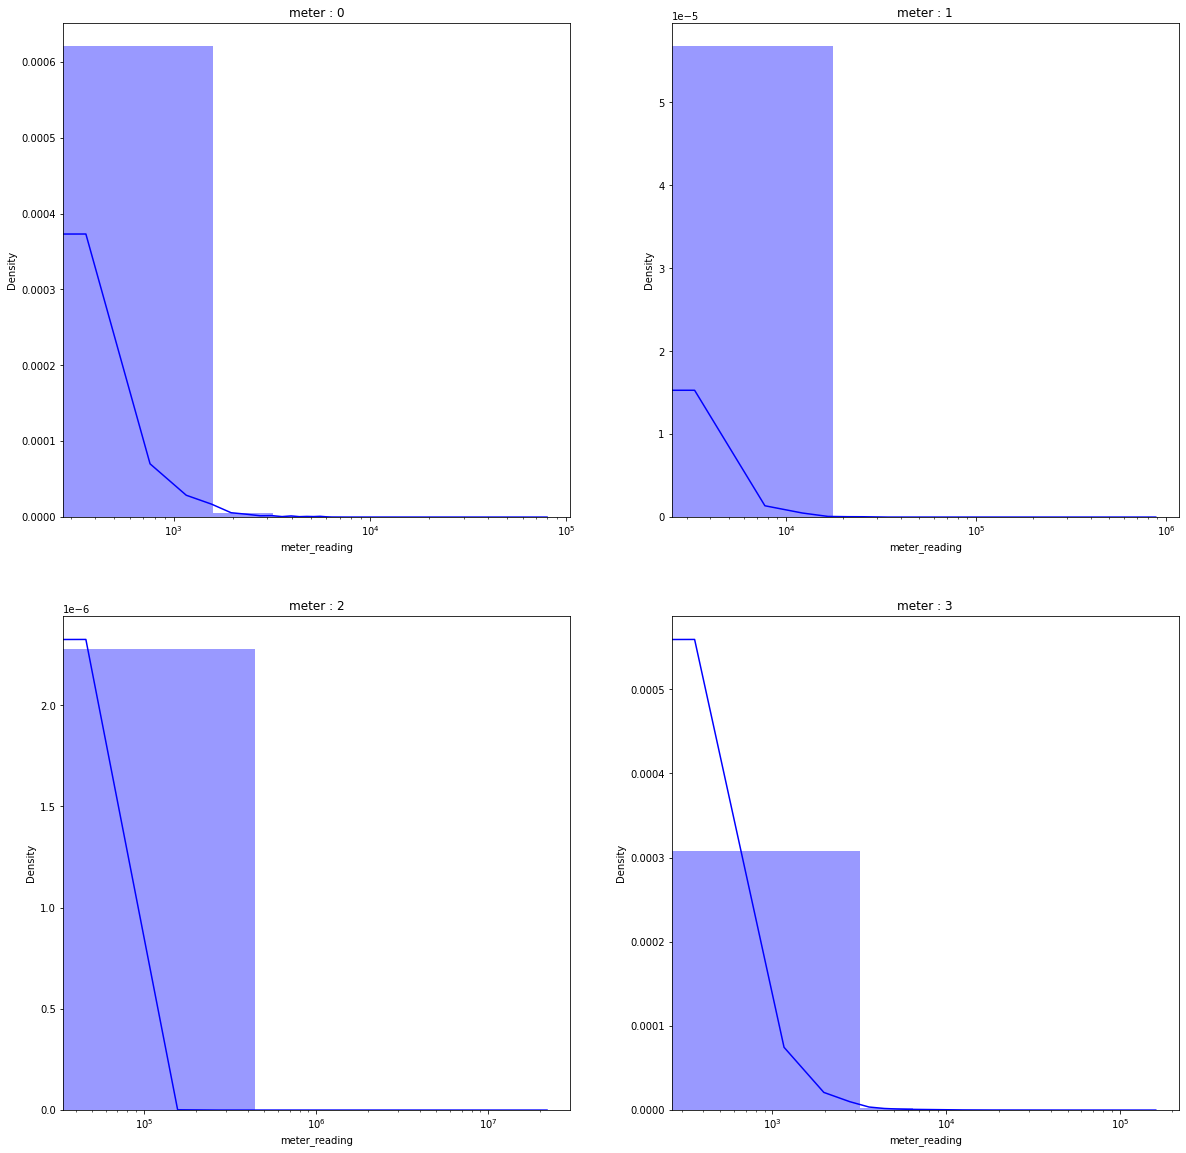

In [ ]:
fig ,axes = plt.subplots(2,2, figsize=(20,20))
meters = [0,1,2,3]
for meter,ax in zip(meters, axes.flat):
  df_meter = df_merge.query(f'meter=={meter}')
  sns.distplot(df_meter['meter_reading'], kde=True, color='blue', ax=ax)
  ax.set_title('meter : '+ str(meter) )
  ax.set_xscale('log')
  # ax.set_yscale('log')


plt.show();

#### Observations

- Looking at the distribution of the meter_reading we can see that for all the four types of meters, there are many outliers and majority of the values lie close to zero. 
  - How does we use this information and make changes?
    - we can remove the ones that have values close to zero - but that might have a bad impact on the model, still to be sure we need to try it out.
    - We can remove the outliers with very high values entirely. Where we see the probability density close to zero. and similarly we can check the performance by doing this and without doing this.
    - How do we proceed to remove the outliers in the first place. 
      - we can remove the rows which have high values for meter_reading, but then how do we decide what is the highest value. We can look at the distribution and see from which value does the distribution goes down to zero. for example, in for meter 3, we can write a fuction to remove all the rows with meter_reading higher than 10^5 (1,00,000).


- Overall I think we can first build a model without deleting any rows and then we could create different models by working with the outliers.


When we try to visualize the meter_reading for the entire data, the system will creash. Instead we will try to visualize for each meters

##### Relationship btw meter_reading & day_of_year

In [ ]:
# sns.relplot(data= df_merge, col = 'meter', y='meter_reading', x='day',kind='line')
# system crashes, instead we do a for loop with lineplot

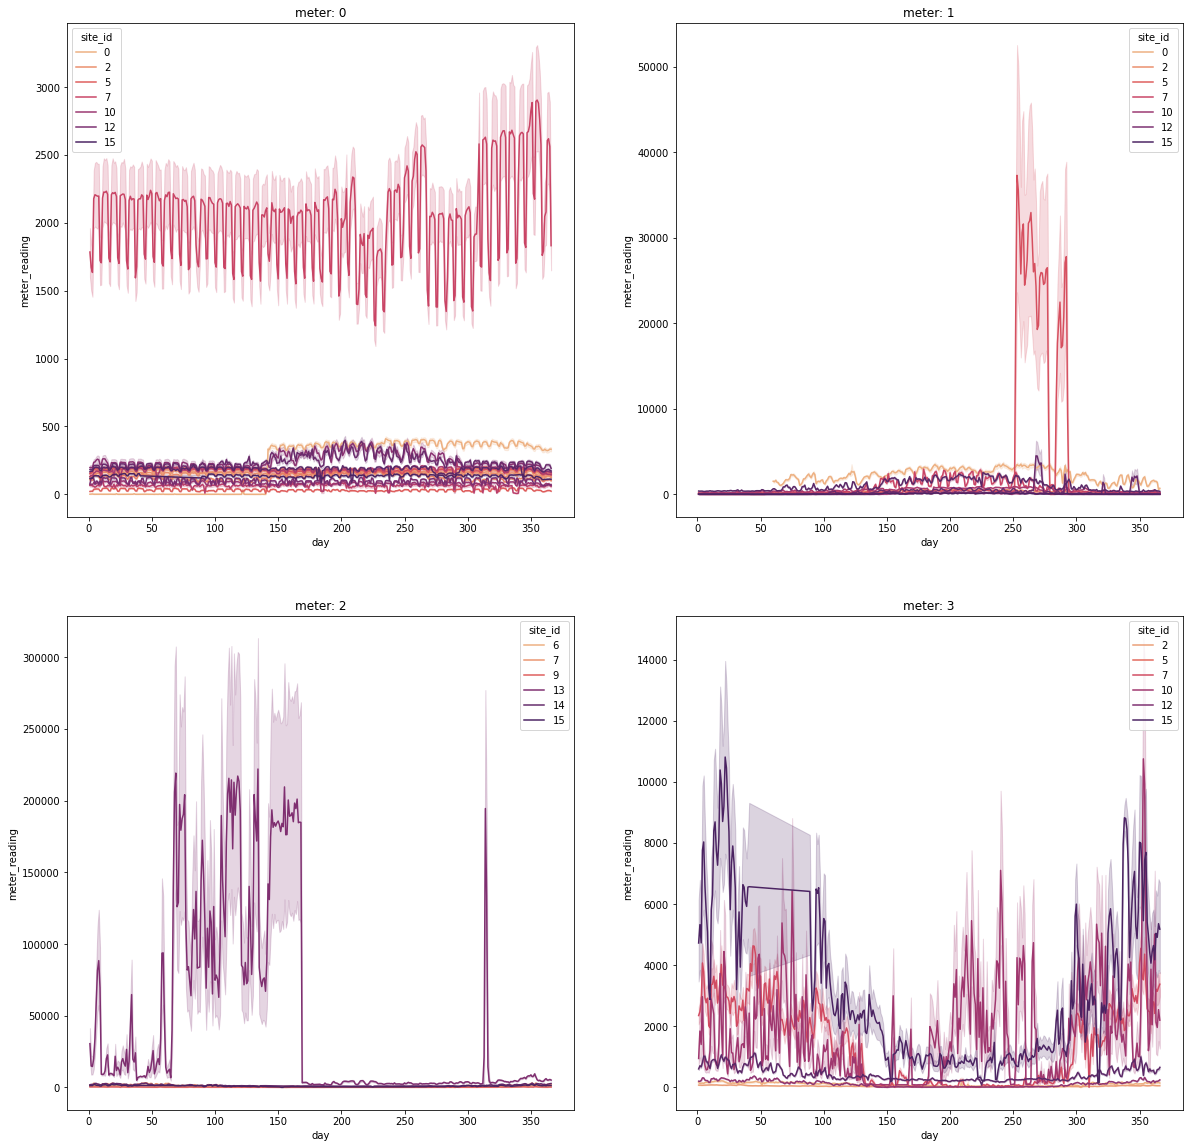

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20,20))


for meter, ax in zip(list(range(0,4)), axes.flat):
  df_meter = df_merge.query(f'meter=={meter}')
  # sns.set_palette('PuBuGn_d')
  sns.lineplot(data= df_meter, x='day',y='meter_reading', hue='site_id',palette="flare" ,ax = ax)
  ax.set_title('meter: ' + str(meter))

plt.show();  

Text(0.5, 1.0, 'meter: 0')

Text(0.5, 1.0, 'meter: 1')

Text(0.5, 1.0, 'meter: 2')

Text(0.5, 1.0, 'meter: 3')

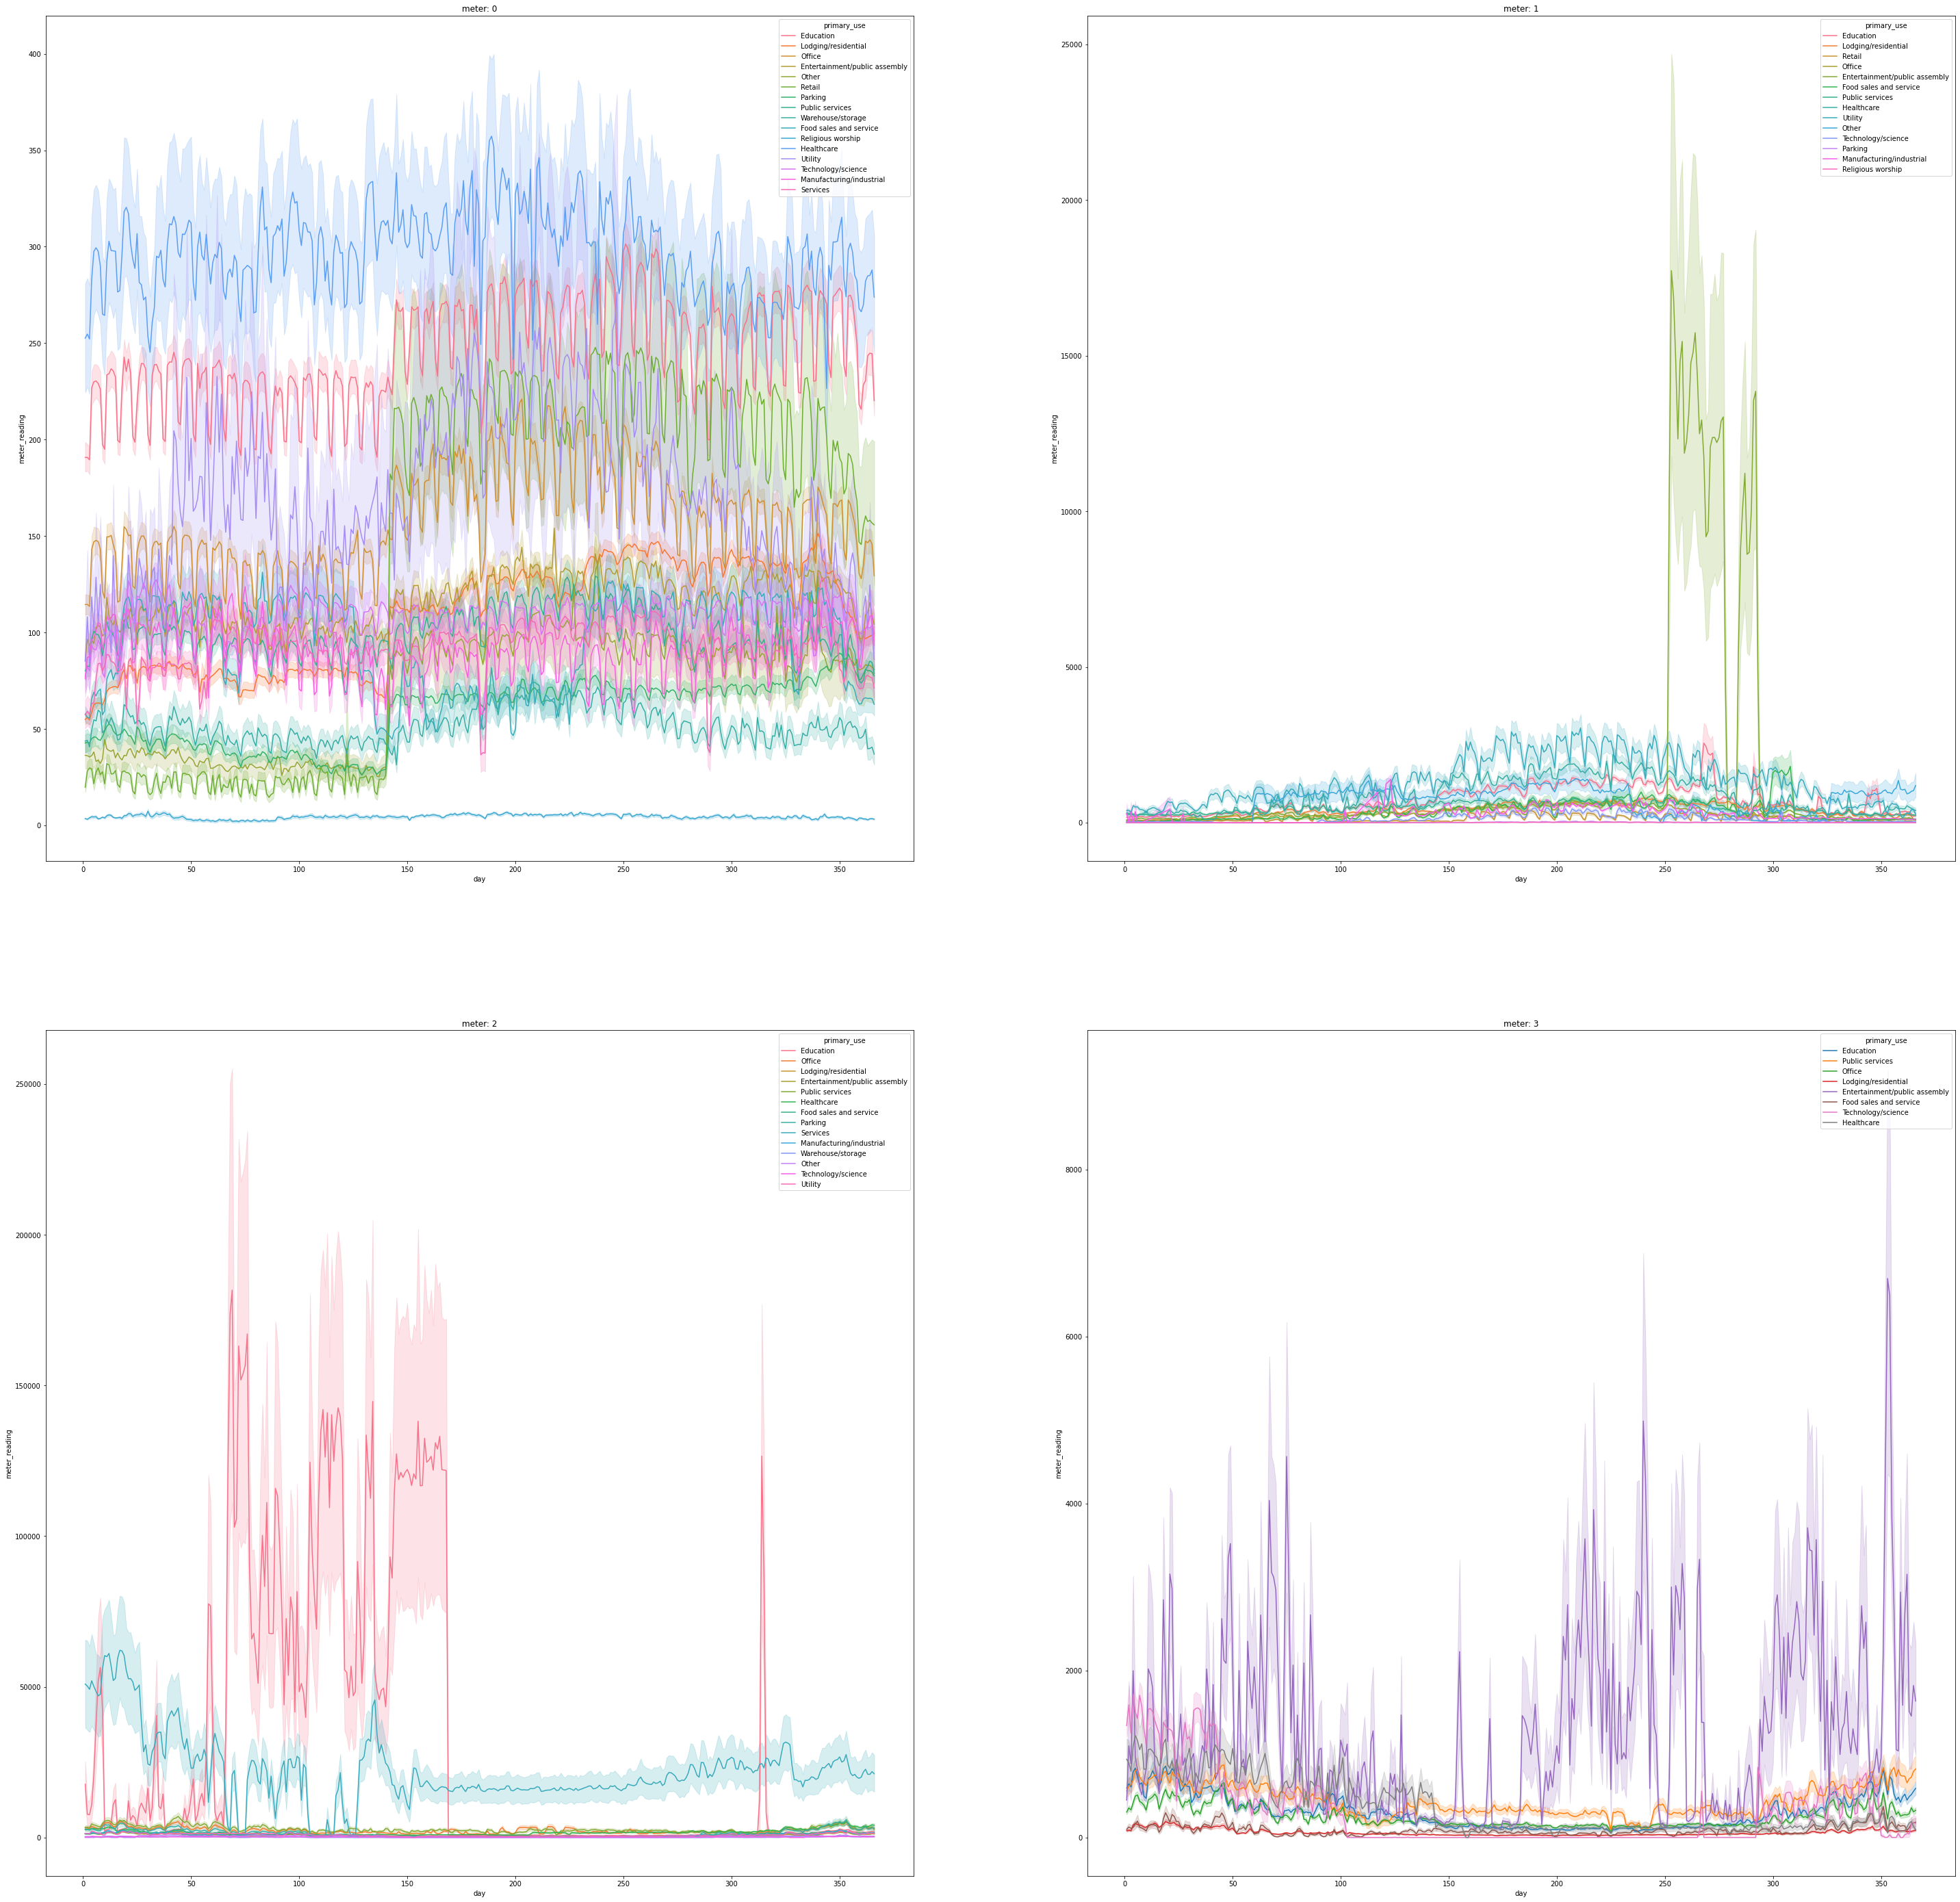

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(25,25))


for meter, ax in zip(list(range(0,4)), axes.flat):
  df_meter = df_merge.query(f'meter=={meter}')
  sns.lineplot(data= df_meter, x='day',y='meter_reading', hue='primary_use',  ax = ax)
  ax.set_title('meter: ' + str(meter))

Text(0.5, 1.0, 'meter: 0')

Text(0.5, 1.0, 'meter: 1')

Text(0.5, 1.0, 'meter: 2')

Text(0.5, 1.0, 'meter: 3')

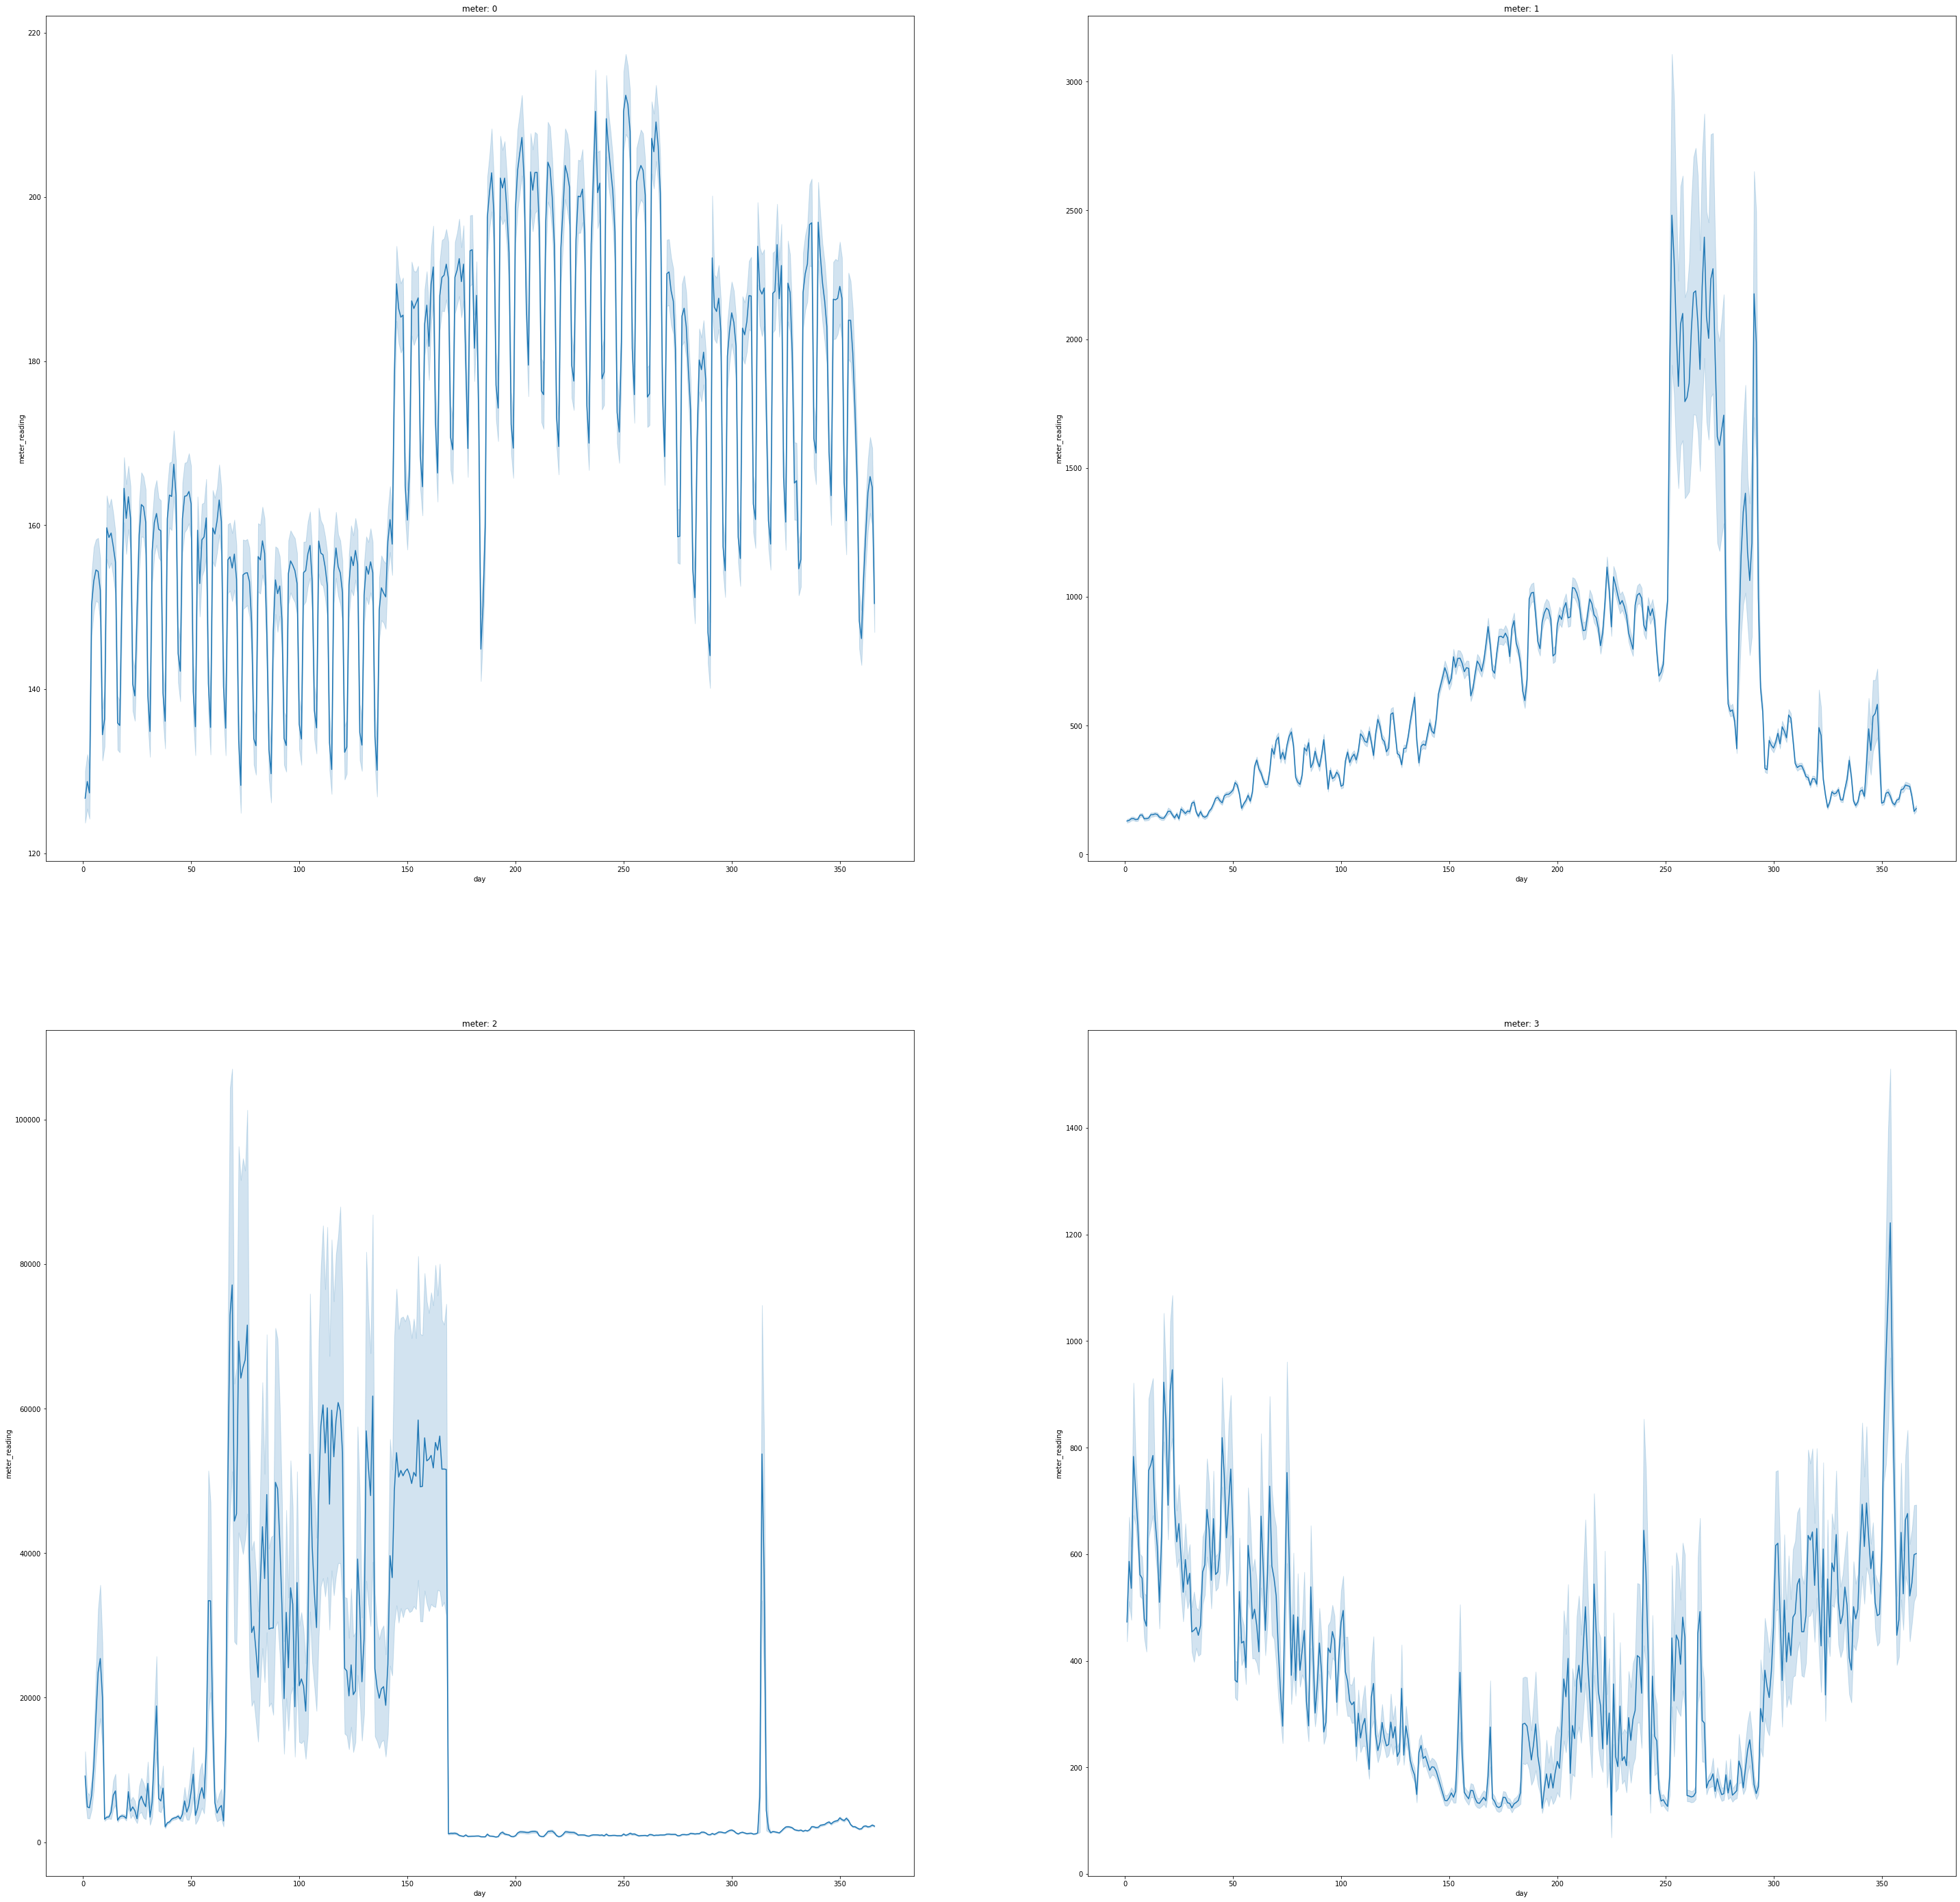

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(50,50))


for meter, ax in zip(list(range(0,4)), axes.flat):
  df_meter = df_merge.query(f'meter=={meter}')
  sns.lineplot(data= df_meter, x='day',y='meter_reading',  ax = ax)
  ax.set_title('meter: ' + str(meter))

#### Observations
- When we look at the distributions of meter_reading for the entire year(per day), for each of the 4 meters we can see that there are spikes of usage at a particular period of the year.
- For some we can see a pattern like for the meter_3.

- The interesting thing is that when we compare the distribution of meter_reading of these 4 meters with individual site_ids and primary_use we see that the spikes are caused either by a particluar type of builing and site id or both. 
  - for example, for meter_2 we see a spike in meter_reading during the 320th day, now when we look at the distributions based on the primary_use and site_id, we see that is caused by 'techology' and 'site-15'.
    - This also means that technology business in site-15 has higher meter_readings compared to other businesses.

  - **The important question we have to ask is, how do i use these insights to improve the model??**
    - After first creating the first model, I can look & compare whether removing the corresponding rows would increase the model performance. 
    - Or create a model just for these outliers and combine with the general model.


### How are we planning to proceed?

we can fill in the data for the other columns ,incase of weather data we can use the mean value, since the weather more or less stays the same for a day.
- we have to look at the data after and before we filled in the missing values.
- see if we need to log the axis for better viz.

### Filling weather details

In [ ]:
df_merge_weather = df_merge.copy()

In [ ]:
tbl_report(df_merge_weather)

Table Shape (20216100, 21)


dtype  ...                                 value_counts
building_id                  int16  ...                                           HC
meter                         int8  ...  0:12060910\n1:4182440\n2:2708713\n3:1264037
timestamp                   object  ...                                           HC
meter_reading              float32  ...                                           HC
site_id                       int8  ...                                           HC
primary_use                 object  ...                                           HC
square_feet                  int32  ...                                           HC
year_built                 float16  ...                                           HC
floor_count                float16  ...                                           HC
air_temperature            float16  ...                                           HC
cloud_coverage             float16  ...                                           HC
dew_temperature            float16  ...                                           HC
precip_depth_1_hr          float16  ...                                           HC
sea_level_pressure         float16  ...                                           HC
wind_direction             float16  ...                                           HC
wind_speed                 float16  ...                                           HC
datetime            datetime64[ns]  ...                                           HC
day                          int64  ...                                           HC
week                         int64  ...                                           HC
month                        int64  ...                                           HC
hour                         int64  ...                                           HC

[21 rows x 5 columns]

#### Filling 

##### Air Temperature

In [ ]:
df_merge_weather = df_merge_weather.set_index(['site_id','month','day'])

In [ ]:
air_filler  = df_merge_weather.groupby(['site_id','month','day'])['air_temperature'].mean()
air_filler_df = pd.DataFrame(air_filler, columns=['air_temperature'])

In [ ]:
df_air_temperature = pd.DataFrame(df_merge_weather['air_temperature'], columns=['air_temperature'])
df_air_temperature.update(air_filler_df, overwrite=False)
df_merge_weather['air_temperature'] = df_air_temperature.values


##### Cloud_coverage

In [ ]:
cloud_coverage_filler = df_weather_train.groupby(['site_id','day','month'])['cloud_coverage'].mean()
# here there will be nan values even after getting mean, as there are days where no cloud values are given for entire day, so even the mean will be nan
cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.astype(np.float64).fillna(method= 'ffill'), columns = ['cloud_coverage']) # method ffill, gets the nearest values to fill na
# converted to float64 to perform ffill method
cloud_coverage = pd.DataFrame(df_weather_train['cloud_coverage'])

cloud_coverage.update(cloud_coverage_filler, overwrite = False)

df_weather_train['cloud_coverage'] = cloud_coverage

KeyError: ignored